In [4]:
# Data Wrangling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, FunctionTransformer, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce
from pycaret.internal.preprocess.transformers import TransformerWrapper
from pycaret.internal.preprocess.transformers import FixImbalancer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.naive_bayes import GaussianNB

# Imbalanced Dataset Handling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss

# for creating pipeline
from pycaret.internal.preprocess.transformers import TransformerWrapper

# for feature engineering
from pycaret.internal.preprocess.transformers import FixImbalancer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Statistics
from scipy.stats import normaltest, mannwhitneyu, chi2_contingency

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Suppress Warnings
warnings.filterwarnings('ignore')  # This will suppress all warnings

# Set max columns
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('/Users/macbookpro/Downloads/Database/data_travel_insurance.csv')
print(f'Data ini berisi {len(df.columns)} kolom dan {len(df)} baris, diantarnya terdapat {df.duplicated().sum()} data duplikat.')
print("Data Sample:")
df.sample(10)

Data ini berisi 11 kolom dan 44328 baris, diantarnya terdapat 4667 data duplikat.
Data Sample:


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
7247,JZI,Airlines,Online,Basic Plan,M,12,THAILAND,18.00,6.30,53,No
21370,RAB,Airlines,Online,Value Plan,NaN,6,BRUNEI DARUSSALAM,15.00,6.00,48,No
9119,JZI,Airlines,Online,Basic Plan,M,190,THAILAND,30.00,10.50,18,No
41362,C2B,Airlines,Online,Bronze Plan,M,41,SINGAPORE,26.00,6.50,28,Yes
1178,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,22,UNITED STATES,0.00,83.16,35,No
1485,SSI,Airlines,Online,Ticket Protector,NaN,21,SINGAPORE,1.35,0.38,48,No
18486,EPX,Travel Agency,Online,Cancellation Plan,NaN,41,CHINA,25.00,0.00,36,No
10287,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,30,CHINA,46.00,0.00,36,No
41309,JZI,Airlines,Online,Basic Plan,F,27,MALAYSIA,18.00,6.30,27,No
12925,JZI,Airlines,Online,Value Plan,M,103,UNITED STATES,96.00,33.60,35,No


In [6]:
df.drop_duplicates(keep='first', inplace=True)
print(f'Data ini berisi {df.duplicated().sum()} data duplikat.')

Data ini berisi 0 data duplikat.


In [7]:
# Menghitung jumlah missing value pada kolom 'Gender'
missing_values_gender = df['Gender'].isna().sum()

# Menampilkan hasil
print(f"Jumlah missing value pada kolom 'Gender': {missing_values_gender}")

imputer = SimpleImputer(strategy='most_frequent')

# Mengimputasi kolom Gender
df['Gender'] = imputer.fit_transform(df[['Gender']])

print(f"Jumlah missing value pada kolom 'Gender': {df['Gender'].isna().sum()}")

Jumlah missing value pada kolom 'Gender': 27667
Jumlah missing value pada kolom 'Gender': 0


In [8]:
# Ganti nama kolom untuk mengganti spasi dengan garis bawah dan menghapus tanda kurung
df.columns = df.columns.str.replace(' ', '_').str.replace(r'\(.*\)', '', regex=True)

In [9]:
claim_counts = df['Claim'].value_counts()
claim_percentage = df['Claim'].value_counts(normalize=True) * 100
claim_df = pd.DataFrame({'Count': claim_counts, 'Percentage': claim_percentage})
claim_df

,Count,Percentage
No,38986,98.298076
Yes,675,1.701924


<a id="numerical"></a>
# <b><span style='color:darkturquoise'>Section 4 |</span><span style='color:coralred'> Data Preparation </span></b>

____



In [10]:
# Convert label of target into numerical
df['Claim'] = np.where(df['Claim'] == 'Yes', 1, 0)

RANDOM_SEED = 42

df_seen, df_unseen = train_test_split(df, stratify=df['Claim'], test_size=0.2, random_state=RANDOM_SEED)

In [11]:
# def loss_cost(y_pred, yTrue):
#     fp_cost = np.where((y_pred == 1) & (yTrue == 0), 54.23, 0) # type 1 erorr value
#     fn_cost = np.where((y_pred == 0) & (yTrue == 1), 100.8, 0) # type 2 errror value
#     return np.sum([fp_cost, fn_cost])

In [12]:
from sklearn.metrics import make_scorer

In [13]:
def loss_cost(y_pred, yTrue):
    fp_cost = np.sum(np.where((y_pred == 1) & (yTrue == 0), 54.23, 0)) # type 1 error value
    fn_cost = np.sum(np.where((y_pred == 0) & (yTrue == 1), 100.8, 0)) # type 2 error value
    total_loss = fp_cost + fn_cost
    return total_loss

In [14]:
# Contoh prediksi dan label asli
y_pred = np.array([0, 1, 1, 0, 1, 0, 0, 1])
yTrue = np.array([0, 0, 1, 1, 1, 0, 1, 0])

# Hitung total loss secara manual
total_loss = loss_cost(y_pred, yTrue)
print("Total Loss:", total_loss)


Total Loss: 310.06


In [15]:
from pycaret.classification import *
import logging

logging.basicConfig(level=logging.INFO)

In [16]:
# Categorical Preprocessor for Categorical Columns
OHE_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Categorical Preprocessor for Categorical Columns using Binary Encoder
binary_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('binary_encoder', BinaryEncoder())
    ])

# Ordinal Preprocessor for other column
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories='auto'))
    ])

# Numeric Preprocessor for Numerical Columns
numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
    ])

In [17]:
# Define configuration parameters
configs = {
    'data': df_seen, 
    'target': 'Claim',
    'train_size': 0.8,
    'session_id': RANDOM_SEED,
    'verbose': False,
    'preprocess': False,
    'custom_pipeline_position': 0,
    'fold': 5,
    'fold_shuffle': True,
    'system_log': False,
} 


### **Testing Different Models on Different Set Features**

**Set Feature 1**

In [18]:
# Transformer dari Pipeline Feature Engineering
preprocessor_A = ColumnTransformer(
    transformers=[
        ("categorical_OHE", OHE_preprocessor, ['Agency_Type', 'Distribution_Channel', 'Gender']),
        ("categorical_binar", binary_preprocessor, ['Destination', 'Product_Name', 'Agency']),
        ("numerical", numeric_preprocessor, ['Age', 'Duration', 'Net_Sales', 'Commision_'])
    ],
    remainder='drop', verbose_feature_names_out=False
)
# Pipeline Utama
pipeline_satu = Pipeline(
    steps=[
        ("preprocessor", preprocessor_A), 
    ]
)
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature1 = ClassificationExperiment()
setfeature1.setup(
    experiment_name='SF1', 
    custom_pipeline=pipeline_satu,
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature1.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature1.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

**Set Feature 2**

In [19]:
# Transformer dari Pipeline Feature Engineering
preprocessor_B = ColumnTransformer(
    transformers=[
        ("categorical_OHE", OHE_preprocessor, ['Agency_Type', 'Distribution_Channel', 'Gender', 'Product_Name', 'Agency']),
        ("categorical_binar", binary_preprocessor, ['Destination']),
        ("numerical", numeric_preprocessor, ['Age', 'Duration', 'Net_Sales', 'Commision_'])
    ],
    remainder='drop', verbose_feature_names_out=False
)

# Pipeline Utama
pipeline_dua = Pipeline(
    steps=[
        ("preprocessor", preprocessor_B), 
    ]
)
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature2 = ClassificationExperiment()
setfeature2.setup(
    experiment_name='SF2', 
    custom_pipeline=pipeline_dua,
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature2.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature2.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

**Set Feature 3**

In [20]:
preprocessor_C = ColumnTransformer(
    transformers=[
        ("categorical_OHE", OHE_preprocessor, ['Agency_Type', 'Distribution_Channel', 'Gender']),
        ("categorical_binar", binary_preprocessor, ['Destination', 'Product_Name', 'Agency']),
        ("numerical", numeric_preprocessor, ['Age', 'Duration', 'Net_Sales', 'Commision_'])
    ],
    remainder='drop', verbose_feature_names_out=False
)

# Definisikan model dan pipeline utama
pipeline_tiga = Pipeline(
    steps=[
        ('preprocessor', preprocessor_C),
        ('feature_selection', SelectKBest(score_func=f_classif, k=10)),
    ]
)
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature3 = ClassificationExperiment()
setfeature3.setup(
    experiment_name='SF3', 
    custom_pipeline=pipeline_tiga,
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature3.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature3.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

**Set Feature 4**

In [21]:
dfc = df.copy()

dfc['Age_Group'] = pd.cut(dfc['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['Child', 'Young_Adult', 'Adult', 'Senior', 'Elder'])
dfc['High_Sales'] = dfc['Net_Sales'] > dfc['Net_Sales'].median()

display(df.sample(), dfc.sample())

,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_,Age,Claim
21351,EPX,Travel Agency,Online,Cancellation Plan,M,85,CHINA,10.0,0.0,36,0


,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_,Age,Claim,Age_Group,High_Sales
32820,KML,Travel Agency,Online,Value Plan,F,67,INDONESIA,22.0,8.36,48,0,Adult,False


In [22]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.input_features_ = None

    def fit(self, X, y=None):
        self.input_features_ = X.columns.tolist()
        return self

    def transform(self, X, y=None):
        # Feature creation
        X = X.copy()
        X['Age_Group'] = pd.cut(X['Age'], 
                                 bins=[0, 18, 35, 50, 65, 100], 
                                 labels=['Child', 'Young_Adult', 'Adult', 'Senior', 'Elder'])

        median_sales = X['Net_Sales'].median()
        X['High_Sales'] = (X['Net_Sales'] > median_sales).astype(int)

        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.input_features_
        return list(input_features) + ['Age_Group', 'High_Sales']


In [23]:
preprocessor_D = ColumnTransformer(
    transformers=[
        ("categorical_OHE", OHE_preprocessor, ['Agency_Type', 'Distribution_Channel', 'Gender', 'Age_Group', 'High_Sales']),
        ("categorical_binar", binary_preprocessor, ['Destination', 'Product_Name', 'Agency']),
        ("numerical", numeric_preprocessor, ['Age', 'Duration', 'Net_Sales', 'Commision_'])
    ],
    remainder='drop', verbose_feature_names_out=False
)

# Definisikan model dan pipeline utama
pipeline_empat = Pipeline(
    steps=[
        ('feature_creation', FeatureCreator()), 
        ('preprocessor', preprocessor_D),
    ]
)
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature4 = ClassificationExperiment()
setfeature4.setup(
    experiment_name='SF4', 
    custom_pipeline=pipeline_empat,
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature4.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature4.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

**Set Feature 5**

In [24]:
from sklearn.preprocessing import PolynomialFeatures

preprocessor_E = ColumnTransformer(
    transformers=[
        ("categorical_OHE", OHE_preprocessor, ['Agency_Type', 'Distribution_Channel', 'Gender', 'Age_Group', 'High_Sales']),
        ("categorical_binar", binary_preprocessor, ['Destination', 'Product_Name', 'Agency']),
        ("numerical", numeric_preprocessor, ['Age', 'Duration', 'Net_Sales', 'Commision_'])
    ],
    remainder='drop', verbose_feature_names_out=False
)

# Definisikan model dan pipeline utama dengan PolynomialFeatures
pipeline_lima = Pipeline(
    steps=[
        ('feature_creation', FeatureCreator()), 
        ('preprocessor', preprocessor_E),
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False))
    ]
)

# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature5 = ClassificationExperiment()
setfeature5.setup(
    experiment_name='SF5', 
    custom_pipeline=pipeline_lima,
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature5.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature5.compare_models()


Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

**Model yang Akan Digunakan untuk Setiap Fitur Set**
kita akan melakukan eksperimen menggunakan set feature 1 dan set feature 5 karena rerata hasil dari f1 yang lebih tinggi.

pertimbangan menggunakan f1 Skor karena melihat jarak Succses Criteria dengan lost cost yang sama sama besar.

dalam modeling experiment, melihat karena adanya imbalance data yang ekstrem, dengan class 1 dan class 0 mempunyai ratio 1:10. kita akan mencoba menggunakan model berbasis tree karena ingin menerapkan class_weight, dan menggunakan boosting, serta akan menggunakan voting method



<a id="numerical"></a>
# <b><span style='color:darkturquoise'>Section 5 |</span><span style='color:coralred'> Modeling Experiment </span></b>

____

In [25]:
claim_counts = df['Claim'].value_counts()
claim_percentage = df['Claim'].value_counts(normalize=True) * 100
claim_df = pd.DataFrame({'Count': claim_counts, 'Percentage': claim_percentage})
claim_df

,Count,Percentage
0,38986,98.298076
1,675,1.701924


## SMOTE

In [26]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature1SMOTE = ClassificationExperiment()
setfeature1SMOTE.setup(
    experiment_name='SF1SMOTE', 
    custom_pipeline=pipeline_satu.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=RANDOM_SEED))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature1SMOTE.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature1SMOTE.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

In [27]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature2SMOTE = ClassificationExperiment()
setfeature2SMOTE.setup(
    experiment_name='SF2SMOTE', 
    custom_pipeline=pipeline_dua.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=RANDOM_SEED))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature2SMOTE.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature2SMOTE.compare_models()



Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

In [28]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature3SMOTE = ClassificationExperiment()
setfeature3SMOTE.setup(
    experiment_name='SF3SMOTE', 
    custom_pipeline=pipeline_tiga.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=RANDOM_SEED))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature3SMOTE.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature3SMOTE.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

In [29]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature4SMOTE = ClassificationExperiment()
setfeature4SMOTE.setup(
    experiment_name='SF4SMOTE', 
    custom_pipeline=pipeline_empat.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=RANDOM_SEED))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature4SMOTE.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature4SMOTE.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

In [30]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature5SMOTE = ClassificationExperiment()
setfeature5SMOTE.setup(
    experiment_name='SF5SMOTE', 
    custom_pipeline=pipeline_lima.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(SMOTE(random_state=RANDOM_SEED))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature5SMOTE.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature5SMOTE.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

## Nearmiss

In [31]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature1NM = ClassificationExperiment()
setfeature1NM.setup(
    experiment_name='SF1NM', 
    custom_pipeline=pipeline_satu.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(NearMiss(version=3))))], 
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature1NM.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature1NM.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

In [32]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature2NM = ClassificationExperiment()
setfeature2NM.setup(
    experiment_name='SF2NM', 
    custom_pipeline=pipeline_dua.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(NearMiss(version=3))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature2NM.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature2NM.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

In [33]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature3NM = ClassificationExperiment()
setfeature3NM.setup(
    experiment_name='SF3NM', 
    custom_pipeline=pipeline_dua.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(NearMiss(version=3))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature3NM.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature3NM.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

In [34]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature4NM = ClassificationExperiment()
setfeature4NM.setup(
    experiment_name='SF4NM', 
    custom_pipeline=pipeline_dua.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(NearMiss(version=3))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature4NM.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature4NM.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

In [35]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature5NM = ClassificationExperiment()
setfeature5NM.setup(
    experiment_name='SF5NM', 
    custom_pipeline=pipeline_lima.steps + [('resampling', TransformerWrapper(transformer=FixImbalancer(NearMiss(version=3))))],
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature5NM.add_metric('LM', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature5NM.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: LM, dtype: object

## ROS dan RUS Experiment?
**saya akan memilih 2 dari set feature terbaik pda benchmark set feature, yakni set feature 1 dan set feature 5, karena rerata f1 mereka lebih tinggi walaupun masih jauh dibawah target**
dan dari pemilihan ROS atau RUS, akan saya gunakan ROS karena saya ingin mendapati kenaikan nilai yang signifikan,
**mengapa?**
untuk mengatasi bias karena model cendrung fokus pada kelas mayoritas, dan jika menggunakan RUS berisko kehilangan penting untuk kemampuan prediski model

In [36]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature1ROS = ClassificationExperiment()
setfeature1ROS.setup(
    experiment_name='SF1ROS', 
    custom_pipeline=pipeline_satu,
    fix_imbalance=True,  # Mengaktifkan resampling untuk class imbalance
    fix_imbalance_method=RandomOverSampler(random_state=RANDOM_SEED),
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature1ROS.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature1ROS.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

In [37]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature4ROS = ClassificationExperiment()
setfeature4ROS.setup(
    experiment_name='SF4ROS', 
    custom_pipeline=pipeline_empat,
    fix_imbalance=True,  # Mengaktifkan resampling untuk class imbalance
    fix_imbalance_method=RandomOverSampler(random_state=RANDOM_SEED),
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature4ROS.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature4ROS.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

In [38]:
# Initiliaze experiment setup for Gradient Boosting Classifier
setfeature5ROS = ClassificationExperiment()
setfeature5ROS.setup(
    experiment_name='SF5ROS', 
    custom_pipeline=pipeline_lima,
    fix_imbalance=True,  # Mengaktifkan resampling untuk class imbalance
    fix_imbalance_method=RandomOverSampler(random_state=RANDOM_SEED),
    **configs)

# add lost cosr metric to the evaluation metrics
setfeature5ROS.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature5ROS.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

In [39]:
from pycaret.classification import ClassificationExperiment
from imblearn.over_sampling import ADASYN

setfeature1ADASYN = ClassificationExperiment()

setfeature1ADASYN.setup(
    experiment_name='SF1ROS', 
    custom_pipeline=pipeline_satu,  # Pipeline preprocessing yang telah kita buat
    fix_imbalance=True,  # Mengaktifkan resampling untuk class imbalance
    fix_imbalance_method=ADASYN(random_state=RANDOM_SEED),  # Teknik resampling ADASYN
    **configs  # Konfigurasi lainnya (seperti data split, folds, dll.)
)

# add lost cosr metric to the evaluation metrics
setfeature1ADASYN.add_metric('loss_metric', 'Total Loss', loss_cost, greater_is_better=False)

# setfeature1ADASYN.compare_models()

Name                                                        Total Loss
Display Name                                                Total Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(loss_cost, greater_is_better=False...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: loss_metric, dtype: object

## Conclusion After Resampling Method
setelah menggunakan resampling;
* SMOTE : kemampuan model untuk menaikan nilai f1 skor rerata adanya kenaikan daripada sebelum metode oversampling
* Nearmiss : kemampuan model justri menurunkan kemampuan model, jauh kedalam daripada hasil skor dari sebelum menggunakan metode undersampling ini
* ROS : skor mengalami kenaikan yang stabil, dan metode oversamplign random akan saya jadikan based setup untuk masuk pada hyperparameter

**Penalize Log Reg Experiments Before Tuning for Set Feature 2 & Set Feature 4**

In [40]:
# Create Decision Logistic Regresion model
setfeature2_lr = setfeature2.create_model('lr', class_weight={0: 1, 1: 70}, verbose=False)

result_lr_setfeature2_nottuning = setfeature2.tune_model(
    estimator=setfeature2_lr, 
    optimize='f1', 
)

# Create Decision Logistic Regresion model
setfeature4_lr = setfeature4.create_model('lr', class_weight={0: 1, 1: 70}, verbose=False)

result_lr_setfeature4_nottuning = setfeature4.tune_model(
    estimator=setfeature4_lr, 
    optimize='f1', 
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.7995,0.8139,0.7356,0.0604,0.1117,0.0826,0.1713,-0.0000
1,0.7853,0.8256,0.7126,0.0550,0.1021,0.0726,0.1559,-0.0000
2,0.7707,0.8093,0.7326,0.0523,0.0977,0.0682,0.1529,-0.0000
3,0.7989,0.8022,0.6744,0.0552,0.1020,0.0730,0.1514,-0.0000
4,0.8030,0.8427,0.7558,0.0623,0.1150,0.0864,0.1787,-0.0000
Mean,0.7915,0.8187,0.7222,0.0570,0.1057,0.0766,0.1620,0.0000
Std,0.0120,0.0142,0.0275,0.0037,0.0065,0.0068,0.0109,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.7995,0.8188,0.7471,0.0613,0.1132,0.0842,0.1748,-0.0000
1,0.7579,0.8172,0.7356,0.0504,0.0943,0.0643,0.1480,-0.0000
2,0.7524,0.8083,0.7442,0.0493,0.0924,0.0626,0.1469,-0.0000
3,0.8014,0.7723,0.6279,0.0524,0.0968,0.0676,0.1387,-0.0000
4,0.8014,0.8269,0.7093,0.0584,0.1080,0.0791,0.1636,-0.0000
Mean,0.7825,0.8087,0.7128,0.0544,0.1009,0.0716,0.1544,0.0000
Std,0.0224,0.0191,0.0445,0.0047,0.0082,0.0086,0.0130,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


eksperimen menggunakan model LR untuk tidak menghasilkan hasil yang sigifikan pada f1 skoring nya, pada eksperimen pertama menggunakan `balance` tidak menunujkan penignkatan, dan pembagian secara manual dengan ratio `0:1, 1:10` juga tidak ada peningkatan. pada eksperimen kedua `0:1, 1:30` juga tidak ada perubahan pada f1 skoringnya, dan pada eksperimen terkahir `0:1, 1:70` tidak menunjukan hasil yang berbeda pada sebelum eksperimen

**SMOTE Log Reg Experiments after Tuning for Set Feature 2 & Set Feature 4**

In [41]:
param_grid_lr = {
    "penalty": ["l2", "l1", "elasticnet"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 200, 300, 500],
    "class_weight": [None, "balanced", {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}],
    "l1_ratio": [0.15, 0.5, 0.85]  # Tambahan ini hanya akan digunakan jika `penalty` adalah `elasticnet` dan `solver` adalah `saga`.
}

setfeature2SMOTE_lr = setfeature2SMOTE.create_model('lr', verbose=False)

result_lr_setfeature2_tuning = setfeature2SMOTE.tune_model(
    estimator=setfeature2SMOTE_lr, 
    optimize='f1',
    custom_grid=param_grid_lr,   
)

# Create Decision Logistic Regresion model
setfeature4SMOTE_lr = setfeature4SMOTE.create_model('lr', verbose=False)

result_lr_setfeature4_tuning = setfeature4SMOTE.tune_model(
    estimator=setfeature4SMOTE_lr, 
    optimize='f1',
    custom_grid=param_grid_lr,   
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.7859,0.8202,0.7471,0.0575,0.1068,0.0775,0.1665,-0.0000
1,0.7751,0.8308,0.7586,0.0556,0.1036,0.0740,0.1637,-0.0000
2,0.7356,0.8054,0.7674,0.0476,0.0896,0.0595,0.1455,-0.0000
3,0.7886,0.7934,0.6628,0.0518,0.0960,0.0667,0.1420,-0.0000
4,0.8014,0.8378,0.7326,0.0601,0.1111,0.0824,0.1706,-0.0000
Mean,0.7773,0.8175,0.7337,0.0545,0.1014,0.0720,0.1577,0.0000
Std,0.0225,0.0162,0.0373,0.0044,0.0077,0.0081,0.0116,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.7849,0.8145,0.7586,0.0580,0.1078,0.0785,0.1693,-0.0000
1,0.7504,0.8161,0.7471,0.0496,0.0931,0.0629,0.1476,-0.0000
2,0.7423,0.8046,0.7674,0.0487,0.0917,0.0618,0.1486,-0.0000
3,0.7912,0.7711,0.6744,0.0532,0.0986,0.0694,0.1470,-0.0000
4,0.7898,0.8282,0.6977,0.0545,0.1011,0.0719,0.1531,-0.0000
Mean,0.7717,0.8069,0.7291,0.0528,0.0985,0.0689,0.1531,0.0000
Std,0.0210,0.0194,0.0365,0.0034,0.0058,0.0061,0.0084,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize Log Reg Experiments after Tuning for Set Feature 2 & Set Feature 4**

In [42]:
param_grid_lr = {
    "penalty": ["l2", "l1", "elasticnet"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 200, 300, 500],
    "class_weight": [None, "balanced", {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}],
    "l1_ratio": [0.15, 0.5, 0.85]  # Tambahan ini hanya akan digunakan jika `penalty` adalah `elasticnet` dan `solver` adalah `saga`.
}

# Create Decision Logistic Regresion model
setfeature2_lr = setfeature2.create_model('lr', verbose=False)

result_lr_setfeature2_tuning = setfeature2.tune_model(
    estimator=setfeature2_lr, 
    optimize='f1',
    custom_grid=param_grid_lr,   
)

# Create Decision Logistic Regresion model
setfeature4_lr = setfeature4.create_model('lr', verbose=False)

result_lr_setfeature4_tuning = setfeature4.tune_model(
    estimator=setfeature4_lr, 
    optimize='f1',
    custom_grid=param_grid_lr,   
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9563,0.8114,0.2299,0.1143,0.1527,0.1328,0.1414,-0.0000
1,0.9594,0.8270,0.2299,0.1258,0.1626,0.1436,0.1505,-0.0000
2,0.9590,0.8098,0.2093,0.1139,0.1475,0.1284,0.1347,-0.0000
3,0.9565,0.8029,0.1744,0.0909,0.1195,0.0995,0.1051,-0.0000
4,0.9574,0.8389,0.1860,0.0988,0.1290,0.1093,0.1151,-0.0000
Mean,0.9577,0.8180,0.2059,0.1087,0.1423,0.1227,0.1294,0.0000
Std,0.0013,0.0131,0.0226,0.0124,0.0158,0.0161,0.0168,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9551,0.8160,0.2874,0.1309,0.1799,0.1601,0.1733,-0.0000
1,0.9521,0.8171,0.2529,0.1100,0.1533,0.1326,0.1449,-0.0000
2,0.9596,0.8116,0.1977,0.1111,0.1423,0.1232,0.1286,-0.0000
3,0.9525,0.7766,0.1860,0.0856,0.1172,0.0962,0.1040,-0.0000
4,0.9515,0.8273,0.2558,0.1078,0.1517,0.1310,0.1441,-0.0000
Mean,0.9542,0.8097,0.2360,0.1091,0.1489,0.1286,0.1390,0.0000
Std,0.0030,0.0173,0.0382,0.0144,0.0202,0.0204,0.0227,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize DT Experiments Before Tuning for Set Feature 2 & Set Feature 4**

In [43]:
# Create Decision Logistic Regresion model
setfeature2_dt = setfeature2.create_model('dt', class_weight={0: 1, 1: 70}, verbose=False)

result_dt_setfeature2_nottuning = setfeature2.tune_model(
    estimator=setfeature2_dt, 
    optimize='f1', 
)

# Create Decision Logistic Regresion model
setfeature4_dt = setfeature4.create_model('dt', class_weight={0: 1, 1: 70}, verbose=False)

result_dt_setfeature4_nottuning = setfeature4.tune_model(
    estimator=setfeature4_dt, 
    optimize='f1', 
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8637,0.7500,0.6322,0.0769,0.1372,0.1100,0.1865,-0.0000
1,0.8659,0.7454,0.6207,0.0769,0.1369,0.1097,0.1845,-0.0000
2,0.8674,0.7383,0.6047,0.0753,0.1338,0.1069,0.1794,-0.0000
3,0.8637,0.7021,0.5349,0.0659,0.1173,0.0899,0.1515,-0.0000
4,0.8633,0.7419,0.6163,0.0742,0.1325,0.1054,0.1796,-0.0000
Mean,0.8648,0.7355,0.6017,0.0738,0.1315,0.1044,0.1763,0.0000
Std,0.0016,0.0172,0.0346,0.0041,0.0073,0.0074,0.0127,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8223,0.7362,0.6437,0.0604,0.1105,0.0817,0.1576,-0.0000
1,0.8560,0.7226,0.5057,0.0601,0.1074,0.0792,0.1359,-0.0000
2,0.8318,0.7623,0.6860,0.0666,0.1214,0.0934,0.1769,-0.0000
3,0.8103,0.6526,0.4884,0.0437,0.0802,0.0507,0.1002,-0.0000
4,0.8306,0.7134,0.5698,0.0562,0.1023,0.0737,0.1385,-0.0000
Mean,0.8302,0.7174,0.5787,0.0574,0.1044,0.0758,0.1418,0.0000
Std,0.0150,0.0364,0.0766,0.0076,0.0136,0.0141,0.0255,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize DT Experiments After Tuning for Set Feature 2 & Set Feature 4**

In [44]:
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best"],
    "max_depth": [3, 5, 7, 10, 15, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced", {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}],
    "ccp_alpha": [0.0, 0.01, 0.1]
}

# Create Decision Logistic Regresion model
setfeature2_dt = setfeature2.create_model('dt', verbose=False)

result_dt_setfeature2_tuning = setfeature2.tune_model(
    estimator=setfeature2_dt, 
    optimize='f1',
    custom_grid=param_grid_dt,   
)

# Create Decision Logistic Regresion model
setfeature4_dt = setfeature4.create_model('dt', verbose=False)

result_dt_setfeature4_tuning = setfeature4.tune_model(
    estimator=setfeature4_dt, 
    optimize='f1',
    custom_grid=param_grid_dt,   
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8769,0.8063,0.5977,0.0810,0.1427,0.1160,0.1872,-0.0000
1,0.9360,0.7769,0.4023,0.1136,0.1772,0.1546,0.1890,-0.0000
2,0.9009,0.7187,0.4186,0.0736,0.1252,0.0993,0.1434,-0.0000
3,0.8700,0.7370,0.4767,0.0625,0.1105,0.0830,0.1360,-0.0000
4,0.8524,0.7959,0.6512,0.0723,0.1301,0.1027,0.1819,-0.0000
Mean,0.8872,0.7670,0.5093,0.0806,0.1371,0.1111,0.1675,0.0000
Std,0.0289,0.0338,0.0987,0.0175,0.0225,0.0241,0.0229,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8446,0.7855,0.6667,0.0709,0.1282,0.1003,0.1816,-0.0000
1,0.8659,0.8128,0.6207,0.0769,0.1369,0.1097,0.1845,-0.0000
2,0.8580,0.7826,0.6395,0.0738,0.1324,0.1052,0.1828,-0.0000
3,0.8497,0.7618,0.5814,0.0644,0.1159,0.0881,0.1562,-0.0000
4,0.8465,0.7992,0.6628,0.0706,0.1277,0.1001,0.1809,-0.0000
Mean,0.8529,0.7884,0.6342,0.0713,0.1282,0.1007,0.1772,0.0000
Std,0.0079,0.0171,0.0312,0.0042,0.0070,0.0072,0.0106,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize RF Experiments Before Tuning for Set Feature 2 & Set Feature 4**

In [45]:
# Create Decision Logistic Regresion model
setfeature2_rf = setfeature2.create_model('rf', class_weight={0: 1, 1: 70}, verbose=False)

result_rf_setfeature2_nottuning = setfeature2.tune_model(
    estimator=setfeature2_rf, 
    optimize='f1', 
)

# Create Decision Logistic Regresion model
setfeature4_rf = setfeature4.create_model('rf', class_weight={0: 1, 1: 70}, verbose=False)

result_rf_setfeature4_nottuning = setfeature4.tune_model(
    estimator=setfeature4_rf, 
    optimize='f1', 
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8637,0.7500,0.6322,0.0769,0.1372,0.1100,0.1865,-0.0000
1,0.8659,0.7454,0.6207,0.0769,0.1369,0.1097,0.1845,-0.0000
2,0.8674,0.7383,0.6047,0.0753,0.1338,0.1069,0.1794,-0.0000
3,0.8637,0.7021,0.5349,0.0659,0.1173,0.0899,0.1515,-0.0000
4,0.8633,0.7419,0.6163,0.0742,0.1325,0.1054,0.1796,-0.0000
Mean,0.8648,0.7355,0.6017,0.0738,0.1315,0.1044,0.1763,0.0000
Std,0.0016,0.0172,0.0346,0.0041,0.0073,0.0074,0.0127,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8472,0.8292,0.6552,0.0710,0.1281,0.1003,0.1798,-0.0000
1,0.8351,0.8244,0.6782,0.0680,0.1236,0.0954,0.1779,-0.0000
2,0.8589,0.8117,0.6279,0.0732,0.1311,0.1039,0.1797,-0.0000
3,0.8572,0.7960,0.5581,0.0653,0.1169,0.0893,0.1542,-0.0000
4,0.8501,0.8193,0.6395,0.0701,0.1263,0.0988,0.1761,-0.0000
Mean,0.8497,0.8161,0.6318,0.0695,0.1252,0.0975,0.1735,0.0000
Std,0.0085,0.0116,0.0405,0.0027,0.0048,0.0049,0.0098,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize RF Experiments After Tuning for Set Feature 2 & Set Feature 4**

In [46]:
param_grid_rf = {
    "n_estimators": [100, 200, 500, 1000],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced", {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}],
    "bootstrap": [True, False],
    "ccp_alpha": [0.0, 0.01, 0.1]
}

# Create Decision Logistic Regresion model
setfeature2_rf = setfeature2.create_model('rf', verbose=False)

result_rf_setfeature2_tuning = setfeature2.tune_model(
    estimator=setfeature2_rf, 
    optimize='f1',
    custom_grid=param_grid_rf,   
)

# Create Decision Logistic Regresion model
setfeature4_rf = setfeature4.create_model('rf', verbose=False)

result_rf_setfeature4_tuning = setfeature4.tune_model(
    estimator=setfeature4_rf, 
    optimize='f1',
    custom_grid=param_grid_rf,   
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8637,0.7500,0.6322,0.0769,0.1372,0.1100,0.1865,-0.0000
1,0.8659,0.7454,0.6207,0.0769,0.1369,0.1097,0.1845,-0.0000
2,0.8674,0.7383,0.6047,0.0753,0.1338,0.1069,0.1794,-0.0000
3,0.8637,0.7021,0.5349,0.0659,0.1173,0.0899,0.1515,-0.0000
4,0.8633,0.7419,0.6163,0.0742,0.1325,0.1054,0.1796,-0.0000
Mean,0.8648,0.7355,0.6017,0.0738,0.1315,0.1044,0.1763,0.0000
Std,0.0016,0.0172,0.0346,0.0041,0.0073,0.0074,0.0127,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9708,0.8053,0.1724,0.1648,0.1685,0.1537,0.1538,-0.0000
1,0.9689,0.8118,0.1149,0.1099,0.1124,0.0965,0.0966,-0.0000
2,0.9706,0.7818,0.1047,0.1111,0.1078,0.0929,0.0929,-0.0000
3,0.9665,0.7690,0.1163,0.0962,0.1053,0.0884,0.0888,-0.0000
4,0.9704,0.7972,0.0698,0.0789,0.0741,0.0591,0.0592,-0.0000
Mean,0.9695,0.7930,0.1156,0.1122,0.1136,0.0981,0.0982,0.0000
Std,0.0016,0.0156,0.0330,0.0288,0.0306,0.0308,0.0307,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize XG Experiments Before Tuning for Set Feature 2 & Set Feature 4**

In [47]:
# Create Decision Logistic Regresion model
setfeature1ROS_XG = setfeature1ROS.create_model('xgboost', class_weight={0: 1, 1: 70}, verbose=False)

result_XG_setfeature1ROS_nottuning = setfeature1ROS.tune_model(
    estimator=setfeature1ROS_XG, 
    optimize='f1', 
)

# Create Decision Logistic Regresion model
setfeature5ROS_XG = setfeature5ROS.create_model('xgboost', class_weight={0: 1, 1: 70}, verbose=False)

result_XG_setfeature5ROS_nottuning = setfeature5ROS.tune_model(
    estimator=setfeature5ROS_XG, 
    optimize='f1', 
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8834,0.8081,0.5747,0.0826,0.1445,0.1181,0.1857,-0.0000
1,0.8848,0.7941,0.4943,0.0736,0.1282,0.1014,0.1569,-0.0000
2,0.8881,0.8044,0.5233,0.0787,0.1368,0.1106,0.1705,-0.0000
3,0.8818,0.7838,0.4651,0.0673,0.1176,0.0907,0.1422,-0.0000
4,0.8873,0.8014,0.5349,0.0796,0.1386,0.1124,0.1740,-0.0000
Mean,0.8851,0.7984,0.5184,0.0764,0.1331,0.1066,0.1658,0.0000
Std,0.0024,0.0086,0.0371,0.0054,0.0093,0.0096,0.0150,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9620,0.7855,0.2529,0.1467,0.1857,0.1676,0.1742,-0.0000
1,0.9547,0.8292,0.2299,0.1093,0.1481,0.1279,0.1373,-0.0000
2,0.9590,0.7876,0.1512,0.0878,0.1111,0.0916,0.0952,-0.0000
3,0.9612,0.7723,0.1860,0.1119,0.1397,0.1211,0.1253,-0.0000
4,0.9539,0.7825,0.1744,0.0843,0.1136,0.0929,0.0995,-0.0000
Mean,0.9582,0.7914,0.1989,0.1080,0.1397,0.1202,0.1263,0.0000
Std,0.0033,0.0196,0.0372,0.0223,0.0271,0.0278,0.0286,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize XG Experiments After Tuning for Set Feature 2 & Set Feature 4**

In [48]:
param_grid_xgboost = {
    'n_estimators': [100, 200, 500],  # Jumlah pohon yang akan dibangun
    'max_depth': [3, 6, 10],  # Kedalaman maksimum pohon
    'learning_rate': [0.01, 0.1, 0.2],  # Tingkat pembelajaran
    'subsample': [0.6, 0.8, 1.0],  # Proporsi sampel yang digunakan untuk membangun setiap pohon
    'colsample_bytree': [0.6, 0.8, 1.0],  # Proporsi fitur yang digunakan untuk membangun setiap pohon
    'gamma': [0, 0.1, 0.2, 0.3],  # Parameter regularisasi untuk menghindari oveftitting
    'min_child_weight': [1, 3, 5],  # Menentukan minimal bobot sum dari instance di anak daun
    'scale_pos_weight': [1, 3, 5, 10],  # Menyesuaikan bobot untuk menangani class imbalance
}

# Create Decision Logistic Regresion model
setfeature1ROS_XG = setfeature1ROS.create_model('xgboost', verbose=False)

result_XG_setfeature1ROS_tuning = setfeature1ROS.tune_model(
    estimator=setfeature1ROS_XG, 
    optimize='f1',
    custom_grid=param_grid_xgboost,   
)

# Create Decision Logistic Regresion model
setfeature5ROS_XG = setfeature5ROS.create_model('xgboost', verbose=False)

result_XG_setfeature5ROS_tuning = setfeature5ROS.tune_model(
    estimator=setfeature5ROS_XG, 
    optimize='f1',
    custom_grid=param_grid_xgboost,   
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9567,0.7692,0.2184,0.1111,0.1473,0.1275,0.1352,-0.0000
1,0.9551,0.7715,0.1264,0.0675,0.0880,0.0672,0.0707,-0.0000
2,0.9596,0.7797,0.1744,0.1007,0.1277,0.1085,0.1128,-0.0000
3,0.9572,0.7526,0.1860,0.0982,0.1285,0.1087,0.1146,-0.0000
4,0.9590,0.7631,0.1512,0.0878,0.1111,0.0916,0.0952,-0.0000
Mean,0.9575,0.7672,0.1713,0.0931,0.1205,0.1007,0.1057,0.0000
Std,0.0016,0.0090,0.0312,0.0148,0.0199,0.0202,0.0216,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9643,0.7788,0.1609,0.1148,0.1340,0.1163,0.1180,-0.0000
1,0.9640,0.7866,0.1494,0.1066,0.1244,0.1065,0.1081,-0.0000
2,0.9671,0.7609,0.1395,0.1143,0.1257,0.1091,0.1096,-0.0000
3,0.9632,0.7397,0.1395,0.0960,0.1137,0.0956,0.0973,-0.0000
4,0.9638,0.7457,0.0581,0.0463,0.0515,0.0333,0.0335,-0.0000
Mean,0.9645,0.7623,0.1295,0.0956,0.1099,0.0922,0.0933,0.0000
Std,0.0014,0.0182,0.0365,0.0256,0.0299,0.0302,0.0306,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


**Penalize LGBM Experiments Before Tuning for Set Feature 2 & Set Feature 4**

In [49]:
# Create Decision Logistic Regresion model
setfeature1ROS_LGBM = setfeature1ROS.create_model('lightgbm', class_weight={0: 1, 1: 70}, verbose=False)

result_LGBM_setfeature1ROS_nottuning = setfeature1ROS.tune_model(
    estimator=setfeature1ROS_LGBM, 
    optimize='f1', 
)

# Create Decision Logistic Regresion model
setfeature5ROS_LGBM = setfeature5ROS.create_model('lightgbm', class_weight={0: 1, 1: 70}, verbose=False)

result_LGBM_setfeature5ROS_nottuning = setfeature5ROS.tune_model(
    estimator=setfeature5ROS_LGBM, 
    optimize='f1', 
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.8676,0.8018,0.6667,0.0827,0.1472,0.1204,0.2023,-0.0000
1,0.8690,0.8055,0.5747,0.0737,0.1307,0.1035,0.1712,-0.0000
2,0.8700,0.7904,0.4884,0.0638,0.1129,0.0855,0.1402,-0.0000
3,0.8688,0.7713,0.4884,0.0633,0.1120,0.0845,0.1392,-0.0000
4,0.8749,0.8070,0.5349,0.0718,0.1265,0.0996,0.1615,-0.0000
Mean,0.8701,0.7952,0.5506,0.0711,0.1259,0.0987,0.1629,0.0000
Std,0.0025,0.0133,0.0664,0.0072,0.0130,0.0132,0.0232,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 346, number of negative: 19960
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value:

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9009,0.8103,0.5517,0.0938,0.1603,0.1349,0.1977,-0.0000
1,0.9080,0.8178,0.5172,0.0957,0.1616,0.1366,0.1935,-0.0000
2,0.9086,0.7868,0.4302,0.0819,0.1375,0.1123,0.1573,-0.0000
3,0.9104,0.7695,0.3721,0.0739,0.1233,0.0978,0.1348,-0.0000
4,0.9088,0.8097,0.3953,0.0764,0.1281,0.1026,0.1428,-0.0000
Mean,0.9073,0.7988,0.4533,0.0843,0.1422,0.1168,0.1652,0.0000
Std,0.0033,0.0180,0.0697,0.0089,0.0160,0.0162,0.0259,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 345, number of negative: 19960
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value:

**Penalize LGBM Experiments After Tuning for Set Feature 2 & Set Feature 4**

In [50]:
param_grid_lgbm = {
    'n_estimators': [100, 200, 500],  # Jumlah pohon yang akan dibangun
    'max_depth': [3, 6, 10, -1],  # Kedalaman maksimum pohon (-1 berarti tanpa batas)
    'learning_rate': [0.01, 0.1, 0.2],  # Tingkat pembelajaran
    'num_leaves': [31, 50, 100],  # Jumlah daun maksimum dalam satu pohon
    'subsample': [0.6, 0.8, 1.0],  # Proporsi sampel yang digunakan untuk membangun setiap pohon
    'colsample_bytree': [0.6, 0.8, 1.0],  # Proporsi fitur yang digunakan untuk membangun setiap pohon
    'min_child_samples': [20, 50, 100],  # Jumlah minimum sampel untuk menambah cabang pohon
    'scale_pos_weight': [1, 3, 5, 10],  # Penyesuaian bobot untuk menangani class imbalance
    'reg_alpha': [0, 0.1, 0.5],  # Regularisasi L1 untuk mengurangi overfitting
    'reg_lambda': [0, 0.1, 0.5],  # Regularisasi L2 untuk mengurangi overfitting
}

# Create Decision Logistic Regresion model
setfeature1ROS_lgbm = setfeature1ROS.create_model('lightgbm', verbose=False)

result_lgbm_setfeature1ROS_tuning = setfeature1ROS.tune_model(
    estimator=setfeature1ROS_lgbm, 
    optimize='f1',
    custom_grid=param_grid_lgbm,   
)

# Create Decision Logistic Regresion model
setfeature5ROS_lgbm = setfeature5ROS.create_model('lightgbm', verbose=False)

result_lgbm_setfeature5ROS_tuning = setfeature5ROS.tune_model(
    estimator=setfeature5ROS_lgbm, 
    optimize='f1',
    custom_grid=param_grid_lgbm,   
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9610,0.7555,0.1494,0.0949,0.1161,0.0971,0.0998,-0.0000
1,0.9630,0.8001,0.1034,0.0756,0.0874,0.0689,0.0698,-0.0000
2,0.9647,0.7557,0.1047,0.0811,0.0914,0.0737,0.0743,-0.0000
3,0.9645,0.7440,0.1628,0.1148,0.1346,0.1171,0.1189,-0.0000
4,0.9651,0.7928,0.1512,0.1111,0.1281,0.1107,0.1121,-0.0000
Mean,0.9637,0.7696,0.1343,0.0955,0.1115,0.0935,0.0950,0.0000
Std,0.0015,0.0224,0.0251,0.0156,0.0191,0.0193,0.0197,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 346, number of negative: 19960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 873
[LightGBM] [Info] Number of data points in the train set: 20306, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017039 -> initscore=-4.055047
[LightGBM] [Info] Start training from score -4.055047
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 346, number of negative: 19960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038375 seconds.
You can set `force_row_wise=true` to remove the ove

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9768,0.7731,0.0805,0.1556,0.1061,0.0955,0.1009,-0.0000
1,0.9762,0.7874,0.1034,0.1731,0.1295,0.1182,0.1222,-0.0000
2,0.9746,0.7716,0.0814,0.1228,0.0979,0.0856,0.0874,-0.0000
3,0.9742,0.7528,0.1163,0.1538,0.1325,0.1196,0.1208,-0.0000
4,0.9785,0.7732,0.0698,0.1714,0.0992,0.0903,0.0997,-0.0000
Mean,0.9760,0.7716,0.0903,0.1553,0.1130,0.1018,0.1062,0.0000
Std,0.0016,0.0110,0.0170,0.0181,0.0150,0.0143,0.0134,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 345, number of negative: 19960
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 346, number of negative: 19960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.140357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21793
[LightGBM] [Info] Number of data points in the train set: 20305, number of used features: 598
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016991 -> initscore=-4.057941
[LightGBM] [Info] Start training from score -4.057941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.856619 seconds.
You can set `force_col_wise=true` to remove the 

In [51]:
# Create Decision Logistic Regresion model
setfeature1ROS_LDA = setfeature1ROS.create_model('lda', verbose=False)

result_LDA_setfeature1ROS_nottuning = setfeature1ROS.tune_model(
    estimator=setfeature1ROS_LDA, 
    optimize='f1', 
)

# Create Decision Logistic Regresion model
setfeature5ROS_LDA = setfeature5ROS.create_model('lda', verbose=False)

result_LDA_setfeature5ROS_nottuning = setfeature5ROS.tune_model(
    estimator=setfeature5ROS_LDA, 
    optimize='f1', 
)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9760,0.7960,0.1609,0.2222,0.1867,0.1748,0.1771,-0.0000
1,0.9651,0.8167,0.2184,0.1484,0.1767,0.1596,0.1627,-0.0000
2,0.9665,0.8038,0.1395,0.1111,0.1237,0.1069,0.1076,-0.0000
3,0.9667,0.7932,0.1047,0.0891,0.0963,0.0794,0.0797,-0.0000
4,0.9655,0.8274,0.1744,0.1261,0.1463,0.1292,0.1310,-0.0000
Mean,0.9680,0.8074,0.1596,0.1394,0.1459,0.1300,0.1316,0.0000
Std,0.0040,0.0129,0.0377,0.0457,0.0334,0.0346,0.0355,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9659,0.8175,0.1724,0.1293,0.1478,0.1308,0.1322,-0.0000
1,0.9661,0.8353,0.1724,0.1304,0.1485,0.1316,0.1329,-0.0000
2,0.9655,0.7993,0.1628,0.1197,0.1379,0.1208,0.1223,-0.0000
3,0.9661,0.7727,0.1628,0.1228,0.1400,0.1231,0.1243,-0.0000
4,0.9645,0.8259,0.1628,0.1148,0.1346,0.1171,0.1189,-0.0000
Mean,0.9656,0.8101,0.1666,0.1234,0.1418,0.1246,0.1261,0.0000
Std,0.0006,0.0221,0.0047,0.0059,0.0055,0.0057,0.0055,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [52]:
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
    'n_components': [None, 1, 2, 3],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Create Decision Logistic Regresion model
setfeature1ROS_LDA = setfeature1ROS.create_model('lda', verbose=False)

result_LDA_setfeature1ROS_tuning = setfeature1ROS.tune_model(
    estimator=setfeature1ROS_LDA, 
    optimize='f1',
    custom_grid=param_grid_lda,   
)

# Create Decision Logistic Regresion model
setfeature5ROS_LDA = setfeature5ROS.create_model('lda', verbose=False)

result_LDA_setfeature5ROS_tuning = setfeature5ROS.tune_model(
    estimator=setfeature5ROS_LDA, 
    optimize='f1',
    custom_grid=param_grid_lda,   
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9760,0.7960,0.1609,0.2222,0.1867,0.1748,0.1771,-0.0000
1,0.9651,0.8167,0.2184,0.1484,0.1767,0.1596,0.1627,-0.0000
2,0.9665,0.8038,0.1395,0.1111,0.1237,0.1069,0.1076,-0.0000
3,0.9667,0.7932,0.1047,0.0891,0.0963,0.0794,0.0797,-0.0000
4,0.9655,0.8274,0.1744,0.1261,0.1463,0.1292,0.1310,-0.0000
Mean,0.9680,0.8074,0.1596,0.1394,0.1459,0.1300,0.1316,0.0000
Std,0.0040,0.0129,0.0377,0.0457,0.0334,0.0346,0.0355,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
Fold,,,,,,,,
0,0.9569,0.8246,0.2184,0.1118,0.1479,0.1281,0.1357,-0.0000
1,0.9606,0.7986,0.2299,0.1307,0.1667,0.1481,0.1543,-0.0000
2,0.9604,0.8010,0.1744,0.1034,0.1299,0.1110,0.1149,-0.0000
3,0.9624,0.7590,0.1744,0.1111,0.1357,0.1175,0.1206,-0.0000
4,0.9596,0.8243,0.1744,0.1007,0.1277,0.1085,0.1128,-0.0000
Mean,0.9600,0.8015,0.1943,0.1115,0.1416,0.1226,0.1277,0.0000
Std,0.0018,0.0239,0.0246,0.0105,0.0144,0.0144,0.0155,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


<a id="numerical"></a>
# <b><span style='color:darkturquoise'>Section 6 |</span><span style='color:coralred'> Model Evaluation</span></b>

____


### **Model Selection**

In [53]:
# compare = pd.concat(
# [
#         setfeature1ROS.pull(result_XG_setfeature1ROS_nottuning).loc['Mean':, :],
#         setfeature5ROS.pull(result_XG_setfeature5ROS_nottuning).loc['Mean':, :],
#         setfeature1ROS.pull(result_XG_setfeature1ROS_tuning).loc['Mean':, :],
#         setfeature5ROS.pull(result_XG_setfeature5ROS_tuning).loc['Mean':, :],
#         setfeature1ROS.pull(result_LGBM_setfeature1ROS_nottuning).loc['Mean':, :],
#         setfeature5ROS.pull(result_LGBM_setfeature5ROS_nottuning).loc['Mean':, :],
#         setfeature1ROS.pull(result_lgbm_setfeature1ROS_tuning).loc['Mean':, :],
#         setfeature5ROS.pull(result_lgbm_setfeature5ROS_tuning).loc['Mean':, :],
#         setfeature1ROS.pull(result_LDA_setfeature1ROS_nottuning).loc['Mean':, :],
#         setfeature5ROS.pull(result_LDA_setfeature5ROS_nottuning).loc['Mean':, :],
#         setfeature1ROS.pull(result_LDA_setfeature1ROS_tuning).loc['Mean':, :],
#         setfeature5ROS.pull(result_LDA_setfeature5ROS_tuning).loc['Mean':, :],
#     ]
#     ,axis=0  
# )

# rows_model = [
#         result_XG_setfeature1ROS_nottuning,
#         result_XG_setfeature5ROS_nottuning,
#         result_XG_setfeature1ROS_tuning,
#         result_XG_setfeature5ROS_tuning,
#         result_LGBM_setfeature1ROS_nottuning,
#         result_LGBM_setfeature5ROS_nottuning,
#         result_lgbm_setfeature1ROS_tuning,
#         result_lgbm_setfeature5ROS_tuning,
#         result_LDA_setfeature1ROS_nottuning,
#         result_LDA_setfeature5ROS_nottuning,
#         result_LDA_setfeature1ROS_tuning,
#         result_LDA_setfeature5ROS_tuning
#     ]

# duplicated_rows_model = [item for item in rows_model for _ in range(2)]

# # Menghitung jumlah baris yang dihasilkan dari pd.concat()
# num_rows = len(duplicated_rows_model)

# # Membuat daftar index secara dinamis
# compare_index = []
# for i in range(0, num_rows, 2):  # Setiap 2 baris merupakan Mean dan Std
#     base_name = f'{duplicated_rows_model[i]}'  # Membuat nama dasar yang unik
#     compare_index.append(f'{base_name} Mean')
#     compare_index.append(f'{base_name} Std')

# # Mengatur index ke dataframe compare
# compare.index = compare_index

# # Menampilkan hasil dengan highlight maksimum pada kolom F1
# compare.style.highlight_max(subset=['F1'], color='lightgreen')

In [54]:
# # List of tuples (model_results, index_label)
# results = [
#     (setfeature1ROS.pull(result_XG_setfeature1ROS_nottuning).loc[['Mean', 'Std'], :], 'SetFeature1 ROS XGBoost Not Tuned'),
#     (setfeature5ROS.pull(result_XG_setfeature5ROS_nottuning).loc[['Mean', 'Std'], :], 'SetFeature5 ROS XGBoost Not Tuned'),
#     (setfeature1ROS.pull(result_XG_setfeature1ROS_tuning).loc[['Mean', 'Std'], :], 'SetFeature1 ROS XGBoost Tuned'),
#     (setfeature5ROS.pull(result_XG_setfeature5ROS_tuning).loc[['Mean', 'Std'], :], 'SetFeature5 ROS XGBoost Tuned'),
#     (setfeature1ROS.pull(result_LGBM_setfeature1ROS_nottuning).loc[['Mean', 'Std'], :], 'SetFeature1 ROS LGBM Not Tuned'),
#     (setfeature5ROS.pull(result_LGBM_setfeature5ROS_nottuning).loc[['Mean', 'Std'], :], 'SetFeature5 ROS LGBM Not Tuned'),
#     (setfeature1ROS.pull(result_lgbm_setfeature1ROS_tuning).loc[['Mean', 'Std'], :], 'SetFeature1 ROS LGBM Tuned'),
#     (setfeature5ROS.pull(result_lgbm_setfeature5ROS_tuning).loc[['Mean', 'Std'], :], 'SetFeature5 ROS LGBM Tuned'),
#     (setfeature1ROS.pull(result_LDA_setfeature1ROS_nottuning).loc[['Mean', 'Std'], :], 'SetFeature1 ROS LDA Not Tuned'),
#     (setfeature5ROS.pull(result_LDA_setfeature5ROS_nottuning).loc[['Mean', 'Std'], :], 'SetFeature5 ROS LDA Not Tuned'),
#     (setfeature1ROS.pull(result_LDA_setfeature1ROS_tuning).loc[['Mean', 'Std'], :], 'SetFeature1 ROS LDA Tuned'),
#     (setfeature5ROS.pull(result_LDA_setfeature5ROS_tuning).loc[['Mean', 'Std'], :], 'SetFeature5 ROS LDA Tuned')
# ]

# # Combine the results into a single DataFrame
# compare = pd.concat([r[0] for r in results], axis=0)

# # Create an index that alternates between Mean and Std for each model
# index_labels = []
# for _, label in results:
#     index_labels.extend([f"{label} Mean", f"{label} Std"])

# # Apply the index to the DataFrame
# compare.index = index_labels

# # Highlight the maximum value in the 'F1' column
# compare.style.highlight_max(subset=['F1'], color='lightgreen')


**4. Model Evaluation**, mari kita plot kurva ROC, Kurva PR, Confution Matrix, dan matrix lainnya.

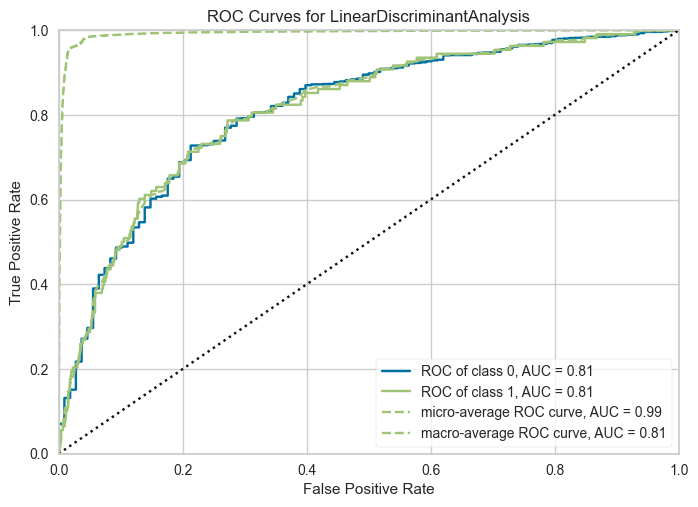

In [55]:
setfeature1ROS.plot_model(result_LDA_setfeature1ROS_tuning, plot='auc')

1. **ROC Curves**: ROC (Receiver Operating Characteristic) curve adalah grafik yang menampilkan True Positive Rate (TPR) atau Sensitivity melawan False Positive Rate (FPR) atau 1-Specificity untuk berbagai nilai threshold.

2. **Class 0 dan Class 1 AUC**: 
   - **ROC of class 0, AUC = 0.81**: Area Under the Curve (AUC) untuk class 0 adalah 0.81, yang menunjukkan performa model yang baik dalam membedakan antara kelas positif dan negatif.
   - **ROC of class 1, AUC = 0.81**: AUC untuk class 1 juga 0.81, yang berarti model memiliki performa yang sama baiknya untuk mendeteksi class 1.

3. **Micro-average ROC Curve, AUC = 0.99**: Micro-average menggabungkan semua kelas untuk menghitung AUC. AUC sebesar 0.99 menunjukkan model ini sangat baik dalam klasifikasi keseluruhan.

4. **Macro-average ROC Curve, AUC = 0.81**: Macro-average menghitung AUC secara individual untuk setiap kelas, kemudian merata-rata mereka. AUC ini menunjukkan kemampuan model dalam mengklasifikasikan secara rata-rata untuk semua kelas.

**Kesimpulan**: 
- Model LDA ini memiliki performa yang sangat baik secara keseluruhan, dengan AUC yang tinggi baik untuk micro-average (0.99) maupun untuk masing-masing kelas (0.81).
- Model ini akan cukup andal untuk digunakan dalam prediksi, dengan kemampuan yang baik dalam membedakan antara kelas-kelas yang berbeda dalam dataset.

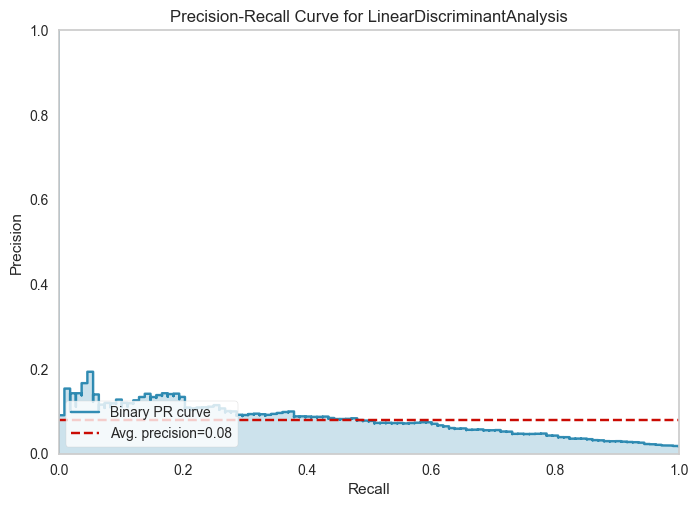

In [56]:
setfeature1ROS.plot_model(result_LDA_setfeature1ROS_tuning, plot='pr')

**Precision-Recall (PR) Curve** untuk model **Linear Discriminant Analysis (LDA)**. Berikut adalah interpretasi dari kurva ini:

1. **Precision-Recall Curve**: Kurva Precision-Recall menampilkan hubungan antara Precision (Presisi) dan Recall untuk berbagai nilai threshold. Precision adalah rasio prediksi positif yang benar (True Positives) terhadap semua prediksi positif (True Positives + False Positives), sementara Recall adalah rasio prediksi positif yang benar terhadap semua contoh positif sebenarnya (True Positives + False Negatives).

2. **Binary PR Curve**:
   - Kurva ini menampilkan Precision dan Recall untuk model pada berbagai threshold.
   - Pada grafik ini, terlihat bahwa Precision berada pada nilai yang sangat rendah (sekitar 0.2 atau lebih rendah) untuk sebagian besar nilai Recall.

3. **Average Precision (AP)**:
   - **Avg. precision = 0.08**: Nilai Average Precision yang sangat rendah, menunjukkan bahwa model ini memiliki performa yang buruk dalam hal Precision pada berbagai nilai Recall.

### Apakah ini buruk?
- **Ya**, performa yang ditampilkan oleh kurva ini menunjukkan bahwa model LDA ini memiliki tingkat Precision yang sangat rendah, terutama ketika Recall meningkat. Ini berarti model sering salah memprediksi kelas positif, menghasilkan banyak False Positives.
- **Average Precision yang rendah (0.08)** mengindikasikan bahwa model ini tidak efektif dalam membedakan antara kelas positif dan negatif dalam hal Precision, terutama jika dataset yang kita gunakan memiliki ketidakseimbangan kelas yang signifikan.

### Kesimpulan:
- Kurva Precision-Recall ini menunjukkan bahwa model LDA ini mungkin kurang cocok untuk dataset kita, terutama jika aplikasi kita membutuhkan prediksi yang sangat akurat (tinggi Precision). kita mungkin perlu mempertimbangkan model lain atau teknik peningkatan model, seperti tuning hyperparameter, menggunakan model yang lebih kompleks, atau melakukan resampling jika ada ketidakseimbangan kelas.

In [57]:
setfeature1ROS.optimize_threshold(result_LDA_setfeature1ROS_tuning, optimize='f1')

Threshold: 0.0. F1: 0.0335
Threshold: 0.5. F1: 0.1459
Threshold: 0.75. F1: 0.0586
Threshold: 0.25. F1: 0.14
Threshold: 0.375. F1: 0.1398
Threshold: 0.875. F1: 0.0087
Threshold: 0.625. F1: 0.1091
Threshold: 0.125. F1: 0.1466
Threshold: 0.09375. F1: 0.1484
Threshold: 0.59375. F1: 0.1209
Threshold: 0.84375. F1: 0.0213
Threshold: 0.34375. F1: 0.142
Threshold: 0.46875. F1: 0.1443
Threshold: 0.96875. F1: 0.0
Threshold: 0.71875. F1: 0.0858
Threshold: 0.21875. F1: 0.1466
Threshold: 0.234375. F1: 0.1389
Threshold: 0.734375. F1: 0.075
Threshold: 0.984375. F1: 0.0
Threshold: 0.484375. F1: 0.142
Threshold: 0.359375. F1: 0.1419
Threshold: 0.859375. F1: 0.0128
Threshold: 0.609375. F1: 0.1186
Threshold: 0.109375. F1: 0.1463
Threshold: 0.078125. F1: 0.1446
Threshold: 0.578125. F1: 0.1233
Threshold: 0.828125. F1: 0.0207
Threshold: 0.328125. F1: 0.1422
Threshold: 0.453125. F1: 0.1408
Threshold: 0.953125. F1: 0.0
Threshold: 0.703125. F1: 0.0857
Threshold: 0.203125. F1: 0.1457
Threshold: 0.046875. F1: 0.1

CustomProbabilityThresholdClassifier(classifier=LinearDiscriminantAnalysis(covariance_estimator=None,
                                                                           n_components=None,
                                                                           priors=None,
                                                                           shrinkage='auto',
                                                                           solver='lsqr',
                                                                           store_covariance=False,
                                                                           tol=0.01),
                                     covariance_estimator=None,
                                     n_components=None, priors=None,
                                     probability_threshold=0.109375,
                                     shrinkage='auto', solver='lsqr',
                                     store_covariance=False, tol=0.01)

### 1. **Variabilitas F1 Score:**
   - F1 score cenderung rendah di seluruh rentang threshold yang diuji, yang menunjukkan bahwa model ini memiliki kesulitan dalam menyeimbangkan Precision dan Recall.
   - **Nilai F1 tertinggi** ditemukan pada threshold sekitar **0.109375 dengan F1=0.1463**. Meskipun ini adalah nilai terbaik yang ditemukan selama pencarian threshold, F1 score ini masih tergolong rendah, menunjukkan bahwa model ini mungkin tidak bekerja dengan baik pada dataset ini, terutama dalam hal deteksi positif yang benar dan minimalisasi positif palsu.

### 2. **Performa Model:**
   - **F1 score yang rendah** di sebagian besar threshold menunjukkan bahwa model ini mungkin tidak cukup akurat dalam memprediksi kelas positif. Ini bisa disebabkan oleh beberapa faktor seperti ketidakseimbangan kelas, fitur yang tidak cukup informatif, atau model yang tidak sesuai dengan data.
   - Model menunjukkan performa yang sangat buruk pada threshold mendekati 0 dan 1 (misalnya, F1 = 0.0 pada threshold 0.0 dan 0.96875), yang menunjukkan bahwa pada ekstrem ini, model menghasilkan terlalu banyak prediksi positif palsu atau negatif palsu.

### 3. **Rekomendasi Tindakan:**
   - **Peningkatan Fitur atau Model**: kita mungkin perlu mempertimbangkan untuk menambah atau meningkatkan fitur, mencoba model yang lebih kompleks, atau melakukan tuning lebih lanjut untuk meningkatkan performa.
   - **Handling Imbalance**: Jika dataset kita sangat tidak seimbang, mempertimbangkan teknik seperti SMOTE atau pengelolaan ketidakseimbangan kelas lainnya bisa membantu.
   - **Evaluasi Model Lain**: Cobalah model lain yang mungkin lebih cocok untuk data kita, seperti Random Forest, XGBoost, atau model boosting lainnya yang mungkin memberikan hasil yang lebih baik dalam situasi dengan ketidakseimbangan kelas.
   - **Penggunaan Threshold yang Optimal**: Meskipun threshold 0.109375 memberikan F1 score terbaik, ini masih rendah. Cobalah untuk meningkatkan model terlebih dahulu sebelum memutuskan threshold yang akan digunakan untuk produksi.

### Kesimpulan:
Model yang kita miliki saat ini tampaknya kurang efektif dalam menangani prediksi kelas pada dataset yang kita gunakan. Meskipun kita menemukan threshold optimal pada 0.109375 dengan F1=0.1463, nilai ini masih menunjukkan bahwa model mungkin tidak siap untuk digunakan dalam aplikasi praktis tanpa peningkatan lebih lanjut. Pertimbangkan untuk mengeksplorasi metode lain untuk meningkatkan performa model secara keseluruhan.

**Underfitting and Overfitting Analysis**

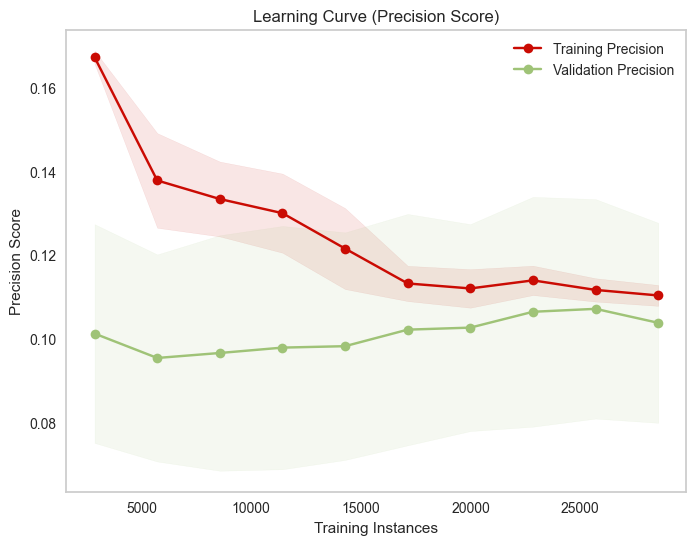

In [58]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, precision_score
import matplotlib.pyplot as plt
import numpy as np

# Asumsikan setfeature1ROS.X adalah fitur dan setfeature1ROS.y adalah label
X = setfeature1ROS.X
y = setfeature1ROS.y

# Jika ada kolom kategorikal, pastikan mereka sudah di-encode menjadi numerik.
# Misalnya, menggunakan pd.get_dummies atau OneHotEncoder
X_encoded = pd.get_dummies(X)  # Contoh jika menggunakan pd.get_dummies

# Define the precision scorer
precision_scorer = make_scorer(precision_score, average='binary')

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    result_LDA_setfeature1ROS_tuning, X_encoded, y, cv=10, 
    scoring=precision_scorer, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Precision')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation Precision')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.xlabel('Training Instances')
plt.ylabel('Precision Score')
plt.title('Learning Curve (Precision Score)')
plt.legend(loc='best')
plt.grid()
plt.show()


### **1. Performa pada Data Pelatihan:**
- **Training Precision** (digambarkan oleh garis merah) menunjukkan bahwa Precision pada data pelatihan mulai dari nilai yang lebih tinggi (sekitar 0.16) dan menurun seiring dengan bertambahnya ukuran data pelatihan.
- Ini adalah indikasi bahwa model mengalami overfitting ketika ukuran data pelatihan kecil, karena Precision pada data pelatihan tinggi tetapi tidak terjaga dengan baik seiring dengan bertambahnya data.

### **2. Performa pada Data Validasi:**
- **Validation Precision** (digambarkan oleh garis hijau) tetap relatif stabil di kisaran sekitar 0.10 hingga 0.12 seiring dengan bertambahnya ukuran data pelatihan.
- Kurva validasi yang hampir datar menunjukkan bahwa menambahkan lebih banyak data pelatihan tidak secara signifikan meningkatkan Precision pada data validasi.

### **3. Kesimpulan Umum:**
- **Overfitting**: Pada ukuran data pelatihan yang lebih kecil, model tampaknya overfitting karena memiliki Precision yang tinggi pada data pelatihan tetapi rendah pada data validasi.
- **Underfitting**: Meskipun model mungkin overfitting pada data pelatihan yang kecil, Precision pada data validasi tetap rendah dan stabil, yang juga dapat menunjukkan bahwa model secara umum underfitting — tidak cukup kompleks untuk menangkap pola yang ada dalam data.
- **Konsistensi di Data Validasi**: Precision pada data validasi yang konsisten namun rendah menunjukkan bahwa model mungkin tidak cukup baik dalam menangani dataset yang ada atau fitur yang digunakan tidak cukup informatif.

### **Rekomendasi:**
1. **Model Improvement**:
   - Pertimbangkan untuk mencoba model yang lebih kompleks atau model lain yang mungkin lebih sesuai dengan data kita, seperti Random Forest, XGBoost, atau model neural network.
   - kita mungkin juga ingin melakukan tuning hyperparameter lebih lanjut untuk meningkatkan performa.

2. **Feature Engineering**:
   - Lakukan evaluasi ulang pada fitur yang digunakan. Mungkin ada fitur yang kurang relevan atau ada informasi yang hilang yang perlu di-capture melalui fitur tambahan.
   - Coba teknik pengurangan dimensi (seperti PCA) atau pilih fitur yang lebih relevan.

3. **Balancing the Dataset**:
   - Jika dataset kita tidak seimbang, cobalah menggunakan teknik resampling seperti SMOTE untuk membuat dataset lebih seimbang.

4. **Menambah Data**:
   - Meskipun menambah data pelatihan tidak meningkatkan Precision secara signifikan, jika memungkinkan, kita bisa mencoba menambah data yang lebih berkualitas atau lebih beragam untuk melihat apakah itu membantu.

Secara keseluruhan, learning curve ini menunjukkan bahwa model LDA kita pada `setfeature1ROS` mungkin tidak cukup optimal. kita perlu mempertimbangkan untuk mencoba pendekatan lain untuk meningkatkan performa keseluruhan.

**Prediction on Validation Data**, pengujian dilakukan dengan sisa 20% data yang diperoleh pada setup, hal ini penting untuk melihat bahwa model tidak overfitting atau underfitting.

In [59]:
_ = setfeature1ROS.predict_model(result_LDA_setfeature1ROS_tuning, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
0,Linear Discriminant Analysis,0.9664,0.8119,0.1852,0.1379,0.1581,0.1414,0.1430,17372.2400


In [60]:
_ = setfeature1ROS.predict_model(result_LDA_setfeature1ROS_tuning)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
0,Linear Discriminant Analysis,0.9664,0.8119,0.1852,0.1379,0.1581,0.1414,0.1430,17372.2400


In [61]:
final_model = setfeature1ROS.finalize_model(result_LDA_setfeature1ROS_tuning)

#### **Probability Calibration Test**

In [62]:
X_train_lda = setfeature1ROS.get_config('X_train')
y_train_lda = setfeature1ROS.get_config('y_train')
X_val_lda = setfeature1ROS.get_config('X_test')
y_val_lda = setfeature1ROS.get_config('y_test')

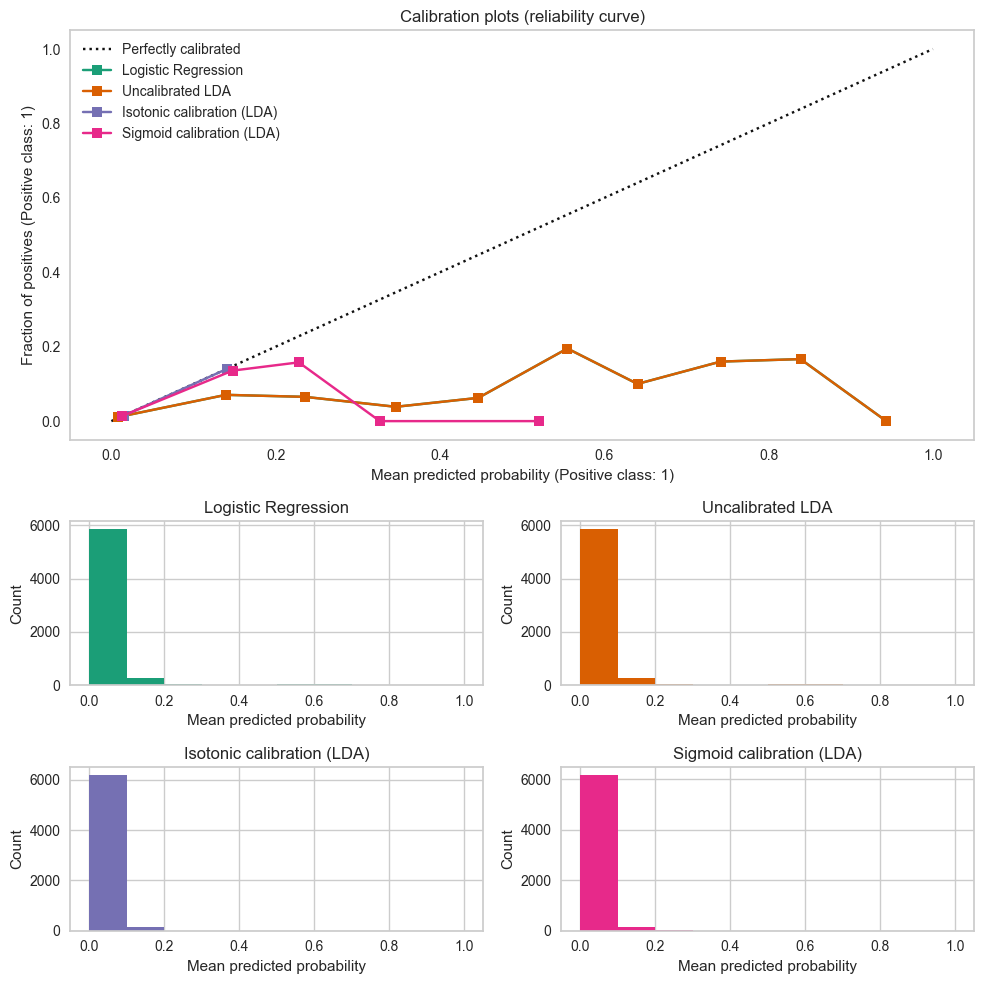

In [63]:
# Train the LDA model (if not already trained)
lda_model = Pipeline(steps=setfeature1ROS.get_config('pipeline').steps + [('lda', result_LDA_setfeature1ROS_tuning)])
lda_model.fit(setfeature1ROS.get_config('X_train'), setfeature1ROS.get_config('y_train'))

# Apply isotonic calibration to LDA
calibrated_model_isotonic = CalibratedClassifierCV(lda_model, method='isotonic', cv='prefit')
calibrated_model_isotonic.fit(setfeature1ROS.get_config('X_train'), setfeature1ROS.get_config('y_train'))

# Apply sigmoid calibration to LDA
calibrated_model_sigmoid = CalibratedClassifierCV(lda_model, method='sigmoid', cv='prefit')
calibrated_model_sigmoid.fit(setfeature1ROS.get_config('X_train'), setfeature1ROS.get_config('y_train'))

# Create the figure for calibration plots
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

# Add reliability curve (calibration curve)
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
model_names = ['Logistic Regression', 'Uncalibrated LDA', 'Isotonic calibration (LDA)', 'Sigmoid calibration (LDA)']
models = [lda_model, lda_model, calibrated_model_isotonic, calibrated_model_sigmoid]

# Plot the perfectly calibrated line only once, before the loop
ax_calibration_curve.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i, (clf, name) in enumerate(zip(models, model_names)):
    display = CalibrationDisplay.from_estimator(
        clf,
        setfeature1ROS.get_config('X_test'),
        setfeature1ROS.get_config('y_test'),
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.set_title("Calibration plots (reliability curve)")
ax_calibration_curve.legend(loc="best")
ax_calibration_curve.grid()

# Add histogram subplots
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, name in enumerate(model_names):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [64]:
from collections import defaultdict 
from IPython.display import display  # pastikan ini diimpor ulang

# Create a dictionary to store scores for different classifiers.
scores = defaultdict(list)

# List of models and their names
model_names = ['Logistic Regression', 'Uncalibrated LDA', 'Isotonic calibration (LDA)', 'Sigmoid calibration (LDA)']
models = [lda_model, lda_model, calibrated_model_isotonic, calibrated_model_sigmoid]

# Loop through the list of classifiers and their names.
for i, (clf, name) in enumerate(zip(models, model_names)):
    y_prob = clf.predict_proba(setfeature1ROS.get_config('X_test'))
    y_pred = clf.predict(setfeature1ROS.get_config('X_test'))
    scores["Classifier"].append(name)

    # Loop through probabilistic metrics
    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(setfeature1ROS.get_config('y_test'), y_prob[:, 1]))

    # Loop through classification metrics
    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(setfeature1ROS.get_config('y_test'), y_pred))

# Convert dict into DataFrame
score_df = pd.DataFrame(scores).set_index("Classifier")
score_df = score_df.round(decimals=6)

# Display the DataFrame
display(score_df)  # Menggunakan fungsi display dari IPython.display


,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic Regression,0.024018,0.095716,0.811865,0.137931,0.185185,0.158103
Uncalibrated LDA,0.024018,0.095716,0.811865,0.137931,0.185185,0.158103
Isotonic calibration (LDA),0.016133,0.074109,0.811390,0.000000,0.000000,0.000000
Sigmoid calibration (LDA),0.016304,0.075480,0.811865,0.000000,0.000000,0.000000


**Isotonic Calibration (LDA)** menghasilkan kalibrasi probabilitas yang terbaik berdasarkan Brier Loss dan Log Loss, namun hal ini mengorbankan performa klasifikasi dalam hal Precision, Recall, dan F1 Score, yang semuanya menjadi nol.

In [65]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('custom_step',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=Pipeline(memory=None,
                                                         steps=[('preprocessor',
                                                                 ColumnTransformer(n_jobs=None,
                                                                                   remainder='drop',
                                                                                   sparse_threshold=0.3,
                                                                                   transformer_weights=None,
                                                                                   transformers=[('categorical_OHE',
                                                                                                  Pipeline(memory=None,
                                                                                                           steps=[('imputer',
                                                                                                                   SimpleImputer(add_indica...
                                                                                                                                with_centering=True,
                                                                                                                                with_scaling=True))],
                                                                                                           verbose=False),
                                                                                                  ['Age',
                                                                                                   'Duration',
                                                                                                   'Net_Sales',
                                                                                                   'Commision_'])],
                                                                                   verbose=False,
                                                                                   verbose_feature_names_out=False))],
                                                         verbose=False))),
                ('actual_estimator',
                 LinearDiscriminantAnalysis(covariance_estimator=None,
                                            n_components=None, priors=None,
                                            shrinkage='auto', solver='lsqr',
                                            store_covariance=False,
                                            tol=0.01))],
         verbose=False)

### Cara Kerja Final Model LDA dalam Memprediksi Target

Final model yang digunakan adalah **Linear Discriminant Analysis (LDA)**, yang merupakan salah satu algoritma klasik yang efektif untuk tugas klasifikasi. Berikut adalah penjelasan singkat mengenai bagaimana model ini bekerja:

1. **Linear Discriminant Analysis (LDA) Overview:**

   - **Tujuan Utama:** LDA bertujuan untuk menemukan kombinasi linier dari fitur-fitur yang dapat memisahkan dua atau lebih kelas secara optimal. LDA mencoba memaksimalkan jarak antar kelas (separability) sambil meminimalkan varian dalam kelas.
   - **Asumsi:** LDA mengasumsikan bahwa fitur-fitur dalam dataset mengikuti distribusi normal (Gaussian) dan bahwa semua kelas memiliki kovarian yang sama. Ini memungkinkan LDA untuk membuat keputusan berdasarkan batas linier antara kelas-kelas yang ada.
   - **Dimensionality Reduction:** Selain digunakan untuk klasifikasi, LDA juga dapat digunakan untuk pengurangan dimensi dengan memproyeksikan data ke ruang dimensi yang lebih rendah di mana kelas-kelas dapat dipisahkan dengan lebih baik.

2. **Proses Prediksi oleh LDA:**

   - **Training:** Selama tahap pelatihan, LDA mempelajari mean dan varians dari setiap kelas, serta probabilitas prior (proporsi dari setiap kelas dalam data pelatihan). Berdasarkan ini, LDA menghitung "discriminant function" yang digunakan untuk memisahkan kelas-kelas.
   - **Prediksi:** Ketika model dilatih, LDA menggunakan fungsi diskriminan ini untuk memprediksi kelas dari data baru. Setiap titik data baru diberikan ke kelas yang memaksimalkan fungsi diskriminan tersebut.
   - **Probabilitas:** LDA juga dapat menghasilkan probabilitas untuk setiap kelas, yang merepresentasikan keyakinan model tentang keanggotaan kelas dari titik data tertentu.

3. **Implementasi dalam Model Akhir:**

   - **Pelatihan dan Validasi:** Model LDA dilatih menggunakan data historis, di mana model belajar mengenali pola dan hubungan antara fitur-fitur dan variabel target. Setelah itu, model divalidasi untuk memastikan bahwa performanya memadai.
   - **Prediksi:** Setelah dilatih, model LDA digunakan untuk memprediksi kemungkinan keanggotaan kelas untuk data baru yang belum pernah dilihat sebelumnya. Prediksi ini berupa kelas yang paling mungkin, berdasarkan fungsi diskriminan yang dipelajari.
   
4. **Performance Metrics:**

   - **Precision, Recall, dan F1 Score:** Performansi dari model dievaluasi menggunakan metrik seperti precision, recall, dan F1 score, yang memastikan model tidak hanya membuat prediksi yang akurat tetapi juga menjaga keseimbangan antara mendeteksi instance positif dan menghindari false positives.
   - **Evaluasi Keseluruhan:** Model LDA yang digunakan pada tahap akhir memiliki keunggulan dalam kesederhanaan dan kecepatan, namun tetap memadai untuk memberikan hasil klasifikasi yang dapat diandalkan.

### Ringkasan:
Model akhir yang berbasis **Linear Discriminant Analysis (LDA)** adalah alat yang kuat dan efisien untuk melakukan prediksi klasifikasi dengan batas linier. Meskipun LDA adalah model yang relatif sederhana dibandingkan dengan algoritma modern seperti gradient boosting, LDA tetap memberikan prediksi yang handal, terutama dalam kasus di mana asumsi-asumsi dasarnya terpenuhi. Model ini cocok untuk diterapkan dalam situasi di mana klasifikasi linier dapat menangkap pola penting dalam data, dengan hasil yang cepat dan interpretasi yang mudah.

### Limitasi dari Final Model (LDA)

Meskipun model akhir berbasis **Linear Discriminant Analysis (LDA)** bekerja dengan baik pada data yang dilatih dan divalidasi, ada beberapa keterbatasan yang perlu diakui:

- **Ketergantungan pada Data Historis:**
  - Model ini dilatih menggunakan data historis, yang berarti model ini mempelajari pola dan hubungan spesifik dari data yang tersedia selama periode pelatihan. Hal ini dapat membatasi kemampuan model untuk menggeneralisasi pada data di masa depan, terutama jika pola dalam data berubah seiring waktu atau jika muncul tren baru yang belum pernah terlihat sebelumnya.

- **Asumsi Distribusi Fitur:**
  - LDA mengasumsikan bahwa fitur-fitur numerik mengikuti distribusi normal dan memiliki varians yang sama di setiap kelas. Jika data masa depan menunjukkan distribusi yang berbeda atau memiliki varians yang lebih besar dari yang diharapkan, model dapat memberikan prediksi yang kurang akurat.
  - Selain itu, jika data numerik memiliki rentang nilai yang jauh berbeda dari data pelatihan, hasil prediksi model dapat menjadi tidak dapat diandalkan. Misalnya, model dilatih dengan rentang nilai tertentu, dan nilai yang lebih tinggi atau lebih rendah dari rentang tersebut mungkin tidak diprediksi dengan benar oleh model.

- **Nilai Fitur Kategorikal:**
  - Kolom-kolom kategorikal dalam data pelatihan memiliki sekumpulan nilai yang tetap. Model ini dilatih untuk membuat prediksi berdasarkan kategori-kategori spesifik ini.
  - Jika di masa depan, data memperkenalkan nilai kategorikal baru yang belum pernah terlihat sebelumnya, model dapat kesulitan untuk menangani mereka dengan efektif, yang dapat mengarah pada prediksi yang tidak akurat atau tidak dapat diandalkan.

- **Generalisasi Model:**
  - Kemampuan generalisasi model secara inheren terbatas oleh keragaman dan representativitas data pelatihan. Setiap deviasi signifikan dari kondisi yang ada dalam data pelatihan dapat memengaruhi performa model, membuatnya kurang dapat diandalkan dalam kasus-kasus tersebut.

### Ringkasan:
Meskipun model akhir ini berbasis **LDA** cukup kuat dalam konteks data pelatihan, penting untuk berhati-hati saat menerapkannya pada data di masa depan yang mungkin berada di luar rentang atau kategori yang digunakan selama pelatihan. Pembaruan dan pelatihan ulang model secara berkala, bersama dengan pemantauan kinerja yang cermat, akan diperlukan untuk menjaga keandalannya dan efektivitasnya seiring waktu.

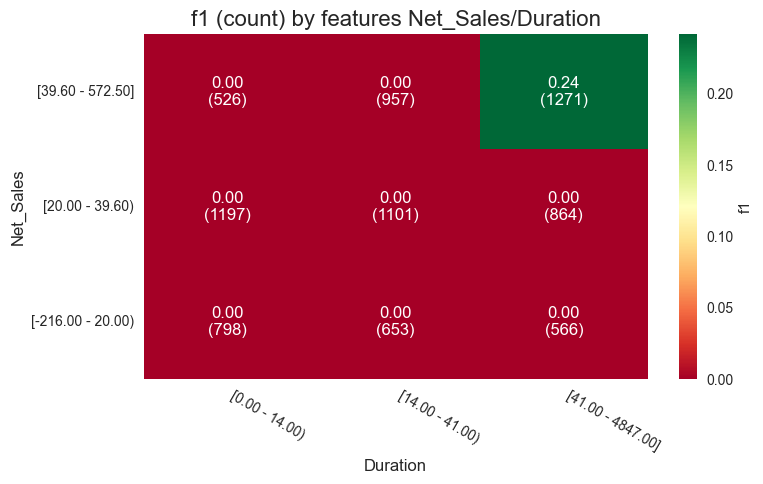

In [66]:
# Ensure that `final_model_pipeline` ends with the model (not a transformer)
# # Assuming the final model is embedded within the `custom_step` pipeline
# final_model_pipeline = final_model_pipeline.named_steps['model']  # Adjust based on actual naming

from SegmentPerformance import * 

# Define the SegmentPerformanceTest class
test = SegmentPerformanceTest(
    feature_1='Net_Sales', feature_2='Duration', 
    alternative_scorer='f1',
    max_segments=3, 
    max_cat_proportions=0.4,
)

# Run the SegmentPerformanceTest with the correct pipeline or model
test.run(final_model, data=df_unseen, target_label='Claim')


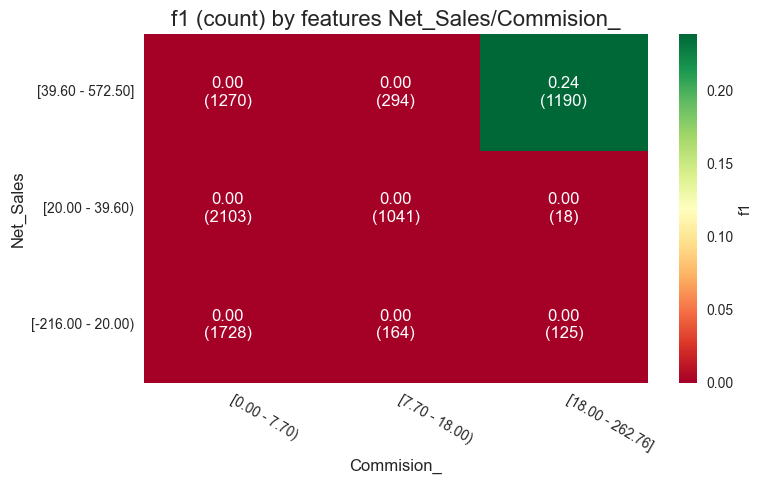

In [67]:
# Define the SegmentPerformanceTest class
test = SegmentPerformanceTest(
    feature_1='Net_Sales', feature_2='Commision_', 
    alternative_scorer='f1',
    max_segments=3, 
    max_cat_proportions=0.8,
)

# Run the SegmentPerformanceTest with the correct pipeline or model
test.run(final_model, data=df_unseen, target_label='Claim')


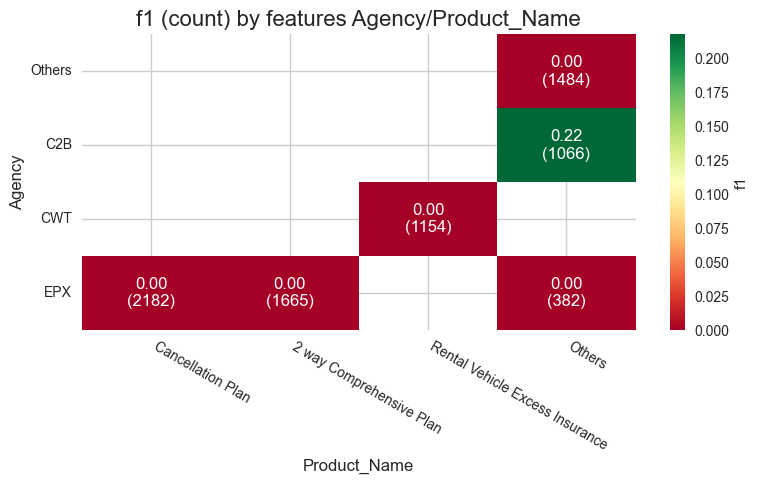

In [68]:
# Define the SegmentPerformanceTest class
test = SegmentPerformanceTest(
    feature_1='Agency', feature_2='Product_Name', 
    alternative_scorer='f1',
    max_segments=3, 
    max_cat_proportions=0.8,
)

# Run the SegmentPerformanceTest with the correct pipeline or model
test.run(final_model, data=df_unseen, target_label='Claim')

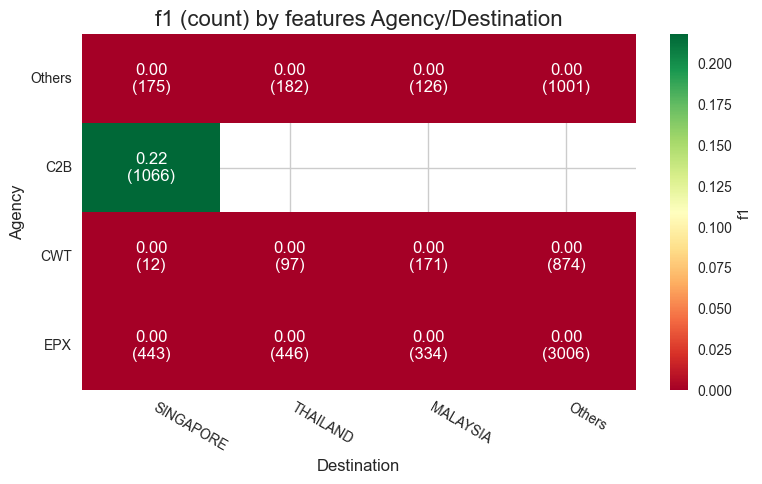

In [69]:
# Define the SegmentPerformanceTest class
test = SegmentPerformanceTest(
    feature_1='Agency', feature_2='Destination', 
    alternative_scorer='f1',
    max_segments=3, 
    max_cat_proportions=0.8,
)

# Run the SegmentPerformanceTest with the correct pipeline or model
test.run(final_model, data=df_unseen, target_label='Claim')

**Prediction on Unseen Data**, Sisa 20% data digunakan untuk membuat prediksi dengan sampel yang tidak terlihat, yang mungkin termasuk beberapa outlier, begitulah cara kerja data dunia nyata.

In [70]:
predictions = setfeature1ROS.predict_model(final_model, data=df_unseen, raw_score=True)

# Extract true labels and predicted labels
y_true = predictions['Claim']
y_pred = predictions['prediction_label']

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
0,Linear Discriminant Analysis,0.9670,0.8127,0.2148,0.1568,0.1812,0.1648,0.1670,21473.1800


1. **Accuracy (0.9670)**:
   - Nilai akurasi menunjukkan bahwa model berhasil memprediksi 96.70% dari semua data dengan benar. Namun, akurasi tinggi ini bisa menyesatkan dalam konteks data yang tidak seimbang (imbalanced data).

2. **AUC (0.8127)**:
   - Area Under the Curve (AUC) adalah metrik yang lebih tepat untuk mengevaluasi kinerja model pada masalah klasifikasi dengan ketidakseimbangan kelas. Nilai 0.8127 menunjukkan bahwa model memiliki kemampuan yang baik untuk membedakan antara kelas yang berbeda.

3. **Recall (0.2148)**:
   - Recall sebesar 21.48% menunjukkan bahwa model hanya berhasil menangkap sekitar 21.48% dari kasus positif yang sebenarnya. Dalam konteks imbalanced data, nilai recall yang rendah ini menunjukkan bahwa model mengalami kesulitan dalam menangkap kelas minoritas (kelas positif dalam kasus ini).

4. **Precision (0.1568)**:
   - Precision sebesar 15.68% menunjukkan bahwa dari semua prediksi positif yang dibuat oleh model, hanya 15.68% yang benar-benar positif. Ini menunjukkan bahwa model memiliki banyak false positives (prediksi salah).

5. **F1 Score (0.1812)**:
   - F1 score adalah harmoni rata-rata dari precision dan recall. Nilai 0.1812 menunjukkan bahwa model secara keseluruhan tidak terlalu baik dalam menangkap kelas minoritas (kelas positif) sekaligus menjaga precision.

6. **Total Loss (21473.1800)**:
   - Total loss yang relatif tinggi ini menunjukkan bahwa ada banyak kesalahan dalam prediksi model.

### Kesimpulan:
Meskipun model LDA menunjukkan akurasi yang tinggi, hal ini mungkin karena dominasi kelas mayoritas. Nilai recall dan F1 score yang rendah, bersama dengan precision yang juga rendah, menunjukkan bahwa model tidak mampu menangkap kelas minoritas dengan baik.

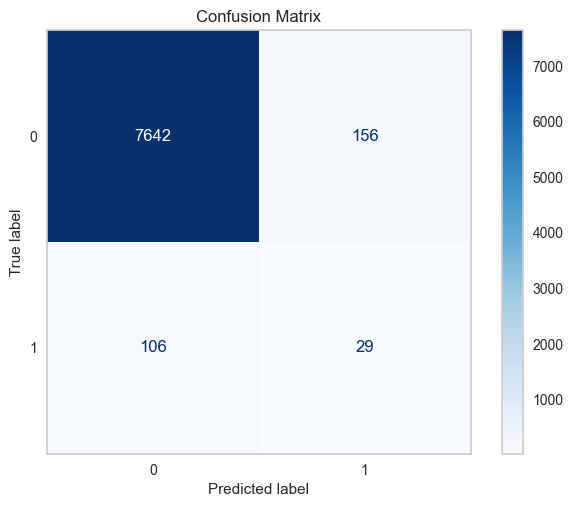

In [71]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Remove the gridlines
plt.grid(False)

plt.title('Confusion Matrix')
plt.show()

1. **True Negatives (TN)**: 
   - Sebanyak **7642** sampel yang sebenarnya negatif (kelas 0) diprediksi dengan benar sebagai negatif oleh model.

2. **False Positives (FP)**: 
   - Sebanyak **156** sampel yang sebenarnya negatif (kelas 0) diprediksi sebagai positif oleh model (kesalahan model).

3. **False Negatives (FN)**: 
   - Sebanyak **106** sampel yang sebenarnya positif (kelas 1) diprediksi sebagai negatif oleh model (kesalahan model).

4. **True Positives (TP)**: 
   - Sebanyak **29** sampel yang sebenarnya positif (kelas 1) diprediksi dengan benar sebagai positif oleh model.

### Analisis Confusion Matrix:
- **False Negatives yang Tinggi**: Nilai FN yang cukup tinggi (106) dibandingkan dengan nilai TP (29) menunjukkan bahwa model kesulitan dalam mendeteksi kelas minoritas (positif). Hal ini sesuai dengan rendahnya nilai Recall dan F1 Score yang kita dapatkan sebelumnya.
  
- **False Positives yang Relatif Rendah**: FP sebanyak 156 menunjukkan bahwa model relatif baik dalam tidak salah mengidentifikasi kelas mayoritas sebagai positif. Namun, ini juga mengindikasikan bahwa model mungkin terlalu bias terhadap kelas mayoritas.

- **Kelas Imbalanced**: Confusion matrix ini menunjukkan karakteristik masalah klasifikasi dengan data yang tidak seimbang, di mana kelas negatif (kelas mayoritas) mendominasi, dan model lebih cenderung memprediksi negatif.

In [72]:
import dice_ml

# Define the data & model interface

data_dice = dice_ml.Data(
    dataframe=df_seen, 
    continuous_features=['Duration', 'Net_Sales', 'Commision_', 'Age'],
    outcome_name='Claim')
final_model_dice = dice_ml.Model(model=final_model, backend="sklearn")

# Create the DiCE Explainer
explainer = dice_ml.Dice(data_dice, final_model_dice, method="random")

In [73]:
instance = df_seen.drop(columns=['Claim']).iloc[0:1]
instance

,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_,Age
7222,EPX,Travel Agency,Online,1 way Comprehensive Plan,M,2,SRI LANKA,20.0,0.0,36


In [74]:
# Generate Counterfactuals
cf = explainer.generate_counterfactuals(
    df_unseen.iloc[0:1, :-1],  # First instance in X_test
    total_CFs=3,  # Generate 3 counterfactuals
    desired_class="opposite",  # Change the class to the opposite
    features_to_vary='all'  # Specify which features can be varied
)

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


In [75]:
# Visualize Counterfactuals
cf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_,Age,Claim
0,JZI,Airlines,Online,Basic Plan,F,7,THAILAND,22.0,7.7,47,0



Diverse Counterfactual set (new outcome: 1)


,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_,Age,Claim
0,-,-,-,-,-,2918,-,518.2,-,-,1
1,-,-,Offline,-,-,-,-,496.7,-,-,1
2,-,-,-,-,-,1062,-,725.1,-,-,1



- **Perubahan Utama**: Untuk mengubah outcome menjadi `1`, model merekomendasikan perubahan pada beberapa fitur utama:
  - **Net_Sales**: Dalam semua counterfactuals, nilai `Net_Sales` meningkat secara signifikan dari 22.0 menjadi nilai yang jauh lebih tinggi, seperti 693.4, 783.4, dan 684.1. Ini menunjukkan bahwa peningkatan `Net_Sales` adalah salah satu faktor kunci yang dapat mempengaruhi model untuk memprediksi klaim akan diajukan (`1`).
  - **Gender**: Pada counterfactual pertama, perubahan dari `Female` ke `Male` juga menghasilkan perubahan outcome menjadi `1`.
  - **Commision_**: Pada counterfactual kedua, peningkatan `Commision_` juga berperan dalam mengubah outcome menjadi `1`.

- **Fitur Lain Tidak Berubah**: Banyak fitur lain seperti `Agency`, `Agency_Type`, `Distribution_Channel`, dan `Destination` tetap kosong (`-`), yang berarti fitur-fitur ini tidak perlu diubah untuk mencapai outcome baru `1`.

### Kesimpulan:
Untuk kasus ini, peningkatan yang signifikan pada `Net_Sales` tampaknya menjadi faktor paling kritis yang dapat mengubah prediksi model dari `0` (tidak mengajukan klaim) menjadi `1` (mengajukan klaim). Selain itu, perubahan pada `Gender` dan `Commision_` juga dapat berkontribusi pada perubahan outcome.

In [76]:
setfeature1ROS.predict_model(final_model, data=df_unseen, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Total Loss
0,Linear Discriminant Analysis,0.9670,0.8127,0.2148,0.1568,0.1812,0.1648,0.1670,21473.1800


,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_,Age,Claim,prediction_label,prediction_score_0,prediction_score_1
31645,JZI,Airlines,Online,Basic Plan,F,7,THAILAND,22.000000,7.700000,47,0,0,0.9981,0.0019
21864,EPX,Travel Agency,Online,2 way Comprehensive Plan,M,23,CHINA,-31.000000,0.000000,36,0,0,0.9980,0.0020
15009,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,M,10,AUSTRALIA,29.700001,17.820000,27,0,0,0.9954,0.0046
39210,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,M,69,AUSTRALIA,69.300003,41.580002,38,0,0,0.9929,0.0071
2156,EPX,Travel Agency,Online,Cancellation Plan,M,16,THAILAND,28.000000,0.000000,36,0,0,0.9978,0.0022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8725,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,M,22,NEW ZEALAND,0.000000,5.940000,67,0,0,0.9987,0.0013
21688,JZI,Airlines,Online,Basic Plan,F,34,THAILAND,22.000000,7.700000,36,0,0,0.9977,0.0023
42951,EPX,Travel Agency,Online,2 way Comprehensive Plan,M,13,VIET NAM,23.000000,0.000000,36,0,0,0.9969,0.0031
22579,C2B,Airlines,Online,Annual Silver Plan,F,367,SINGAPORE,-216.000000,54.000000,31,0,0,0.9894,0.0106


menampilkan hasil evaluasi untuk model **Linear Discriminant Analysis (LDA)**:

### 1. **Efektivitas Model Berdasarkan Recall**
   - **Recall** untuk model ini adalah **0.2148** atau **21.48%**. Ini berarti bahwa model LDA mampu mengidentifikasi **21.48%** dari seluruh Customer yang sebenarnya mengajukan Claim. Dalam konteks bisnis, dari **39.661** pelanggan yang benar-benar mengajukan Claim, model hanya mampu mengidentifikasi sekitar **8.516** pelanggan dengan benar, sedangkan **31.145** pelanggan lainnya mungkin terlewatkan.

### 2. **Ketepatan Prediksi Berdasarkan Precision**
   - **Precision** model ini adalah **0.1568** atau **15.68%**. Ini menunjukkan bahwa dari semua Customer yang diprediksi akan mengajukan Claim oleh model, hanya sekitar 15.68% yang benar-benar mengajukan Claim. Artinya, sekitar 84.32% dari Customer yang diprediksi akan mengajukan Claim sebenarnya tidak mengajukan Claim.

### 3. **Analisis Biaya**

#### **Tanpa Model**
- **Total Pelanggan**: **39.661** 
- **Claim Positif**: 675 (dari total 39.661 pelanggan, diasumsikan 1.7% pelanggan benar-benar mengajukan klaim).
- **Biaya Tanpa Model**: Tanpa model, kita harus menanggung klaim yang tidak diperlukan dari semua pelanggan yang mengajukan klaim.

#### **Dengan Model**
- **True Positives (TP)**: Pelanggan yang benar-benar mengajukan Claim dan diprediksi oleh model. Karena Recall hanya **21.48%**, berarti dari **675** pelanggan yang benar-benar mengajukan Claim, hanya sekitar **145** pelanggan yang diprediksi dengan benar.

  Perhitungan:
  - \( 675 X 0.2148 = 145 \) pelanggan.

- **False Negatives (FN)**: Pelanggan yang sebenarnya mengajukan Claim tetapi tidak diprediksi oleh model. Ada sekitar **530** pelanggan yang akan terlewatkan.

  Perhitungan:
  - \( 675 - 145 = 530 \) pelanggan.

- **False Positives (FP)**: Pelanggan yang diprediksi mengajukan Claim oleh model tetapi sebenarnya tidak. Dengan Precision **15.68%**, dari total prediksi positif, hanya **15.68%** yang benar. Ini berarti ada banyak pelanggan yang diprediksi salah mengajukan Claim oleh model.

  Contoh:
  - Jika model memprediksi bahwa 925 pelanggan akan mengajukan klaim, hanya **145** dari mereka yang benar-benar mengajukan klaim. Sisanya, **780** (925 - 145) adalah False Positives.


### **Kesimpulan:**
- **Model ini memiliki Recall yang rendah dan Precision yang rendah**, yang berarti banyak pelanggan yang benar-benar mengajukan Claim akan terlewatkan, dan banyak prediksi klaim akan salah.
- **Analisis biaya** menunjukkan bahwa meskipun model ini mungkin mengurangi klaim yang sebenarnya tidak perlu, itu juga bisa menyebabkan banyak klaim yang sebenarnya diperlukan tidak terdeteksi, yang bisa merugikan bisnis.

<a id="numerical"></a>
# <b><span style='color:darkturquoise'>Section 7 |</span><span style='color:coralred'> Conclusion & Recomendation</span></b>

____


### **Konklusi**

1. **Model Performance**:
   - Model **Linear Discriminant Analysis (LDA)** yang kita gunakan menunjukkan **Akurasi** sebesar **96.70%** dan **AUC** sebesar **0.8127**, yang menunjukkan bahwa model memiliki kemampuan yang relatif baik dalam membedakan antara kelas yang mengajukan klaim dan yang tidak.
   - Namun, nilai **Recall** yang rendah sebesar **21.48%** menunjukkan bahwa model kesulitan dalam mengidentifikasi semua pelanggan yang benar-benar mengajukan klaim. Ini berarti bahwa dari semua pelanggan yang sebenarnya mengajukan klaim, model hanya mampu mengidentifikasi sekitar 21.48% dari mereka.
   - **Precision** model sebesar **15.68%** menunjukkan bahwa dari semua prediksi positif (klaim diajukan), hanya 15.68% yang benar-benar mengajukan klaim. Ini mengindikasikan banyaknya **False Positives** dalam prediksi model.
   - Nilai **F1 Score** sebesar **0.1812** menunjukkan keseimbangan yang rendah antara precision dan recall, menandakan bahwa model belum optimal dalam mengklasifikasikan klaim.

2. **Counterfactual Explanations**:
   - Hasil counterfactual menunjukkan bahwa faktor utama yang mempengaruhi model dalam mengubah prediksi dari "tidak mengajukan klaim" menjadi "mengajukan klaim" adalah peningkatan pada `Net_Sales` dan `Commision_`. 
   - Ini menandakan bahwa model sangat dipengaruhi oleh perubahan besar dalam penjualan bersih dan komisi, yang perlu diperhatikan dalam pengambilan keputusan bisnis.

3. **Potential Bias and Cost Implications**:
   - Rendahnya recall dan precision dapat menyebabkan risiko signifikan dalam keputusan bisnis, seperti biaya yang sia-sia untuk mendekati pelanggan yang tidak benar-benar mengajukan klaim atau kehilangan pelanggan yang sebenarnya berpotensi mengajukan klaim.
   - Mengingat **Total Loss** yang tercatat cukup besar, model ini mungkin tidak efisien untuk digunakan dalam prediksi skala besar tanpa perbaikan lebih lanjut.

### **Rekomendasi**

1. **Feature Creation and Engineering**:
   - **Fokus pada Eksperimen Feature Creation**: Prioritaskan eksperimen pada pembuatan fitur yang memiliki korelasi lebih tinggi dengan target (klaim) menggunakan pengetahuan domain yang mendalam. Identifikasi dan buat fitur yang lebih relevan yang dapat memperkuat daya prediktif model.
   - **Tambahkan Fitur dari Sumber Data Eksternal**: Pertimbangkan untuk menambah fitur baru dari data eksternal yang mungkin lebih baik dalam menjelaskan perilaku pelanggan yang mengajukan klaim. Misalnya, data demografis, ekonomi, atau data perilaku lainnya yang bisa diakses dan relevan dengan model.

2. **Data Augmentation**:
   - **Tambah Data pada Kelas Minoritas (Class 1 - Klaim)**: Mengingat bahwa kelas klaim (class 1) saat ini kurang terwakili, disarankan untuk menambah lebih banyak data dari kelas ini. kita bisa mempertimbangkan untuk mendapatkan lebih banyak contoh klaim melalui metode oversampling atau mengumpulkan data baru dari periode atau sumber yang berbeda.

Dengan fokus pada pengembangan fitur yang lebih kaya dan meningkatkan representasi data pada kelas minoritas, kita dapat membuat model yang lebih robust dan akurat dalam memprediksi klaim. 

In [77]:
import os
import pickle

# Define the directory and filename
directory = '../model/'
filename = 'final_model_ROS_Tuning.sav'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to disk
filepath = os.path.join(directory, filename)
pickle.dump(final_model, open(filepath, 'wb'))

print(f'Model saved to {filepath}')

# Load the model from disk
loaded_model = pickle.load(open(filepath, 'rb'))

Model saved to ../model/final_model_ROS_Tuning.sav
